# COMS4060A - Introduction of Data Visualisation & Exploration: Assignment 2 

## Group Members
* Lisa Godiwn - 2437980
* Nihal Ranchod - 2427378
* Zach Schwark - 2434346

## Coding Practices

- Dataframe `df` is the original data.
- `df_copy` is a copy of the original dataframe `df` and is used only at the start of the data cleaning process in Question 1.
- `df` used from Question 3 onwards is a new dataframe created by using a cleaned .csv file that is created at the end of Question 2. 

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
from folium.plugins import HeatMap
import warnings
import os
from sklearn.cluster import DBSCAN
import builtins
warnings.filterwarnings("ignore")
import gc

Reading in the .csv and creating a dataframe.


In [89]:
df = pd.read_csv("./nyc_taxis/nyc_taxis.csv")

df_copy = df.copy()
display(df_copy.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


### Question 1: Data Cleaning

Data Exploration: Check for missing values, basic statistics, and unsual data points.

In [90]:
display(df_copy.info())
pd.set_option('display.float_format', '{:.3f}'.format)
display(df_copy.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


None

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [91]:
missing_values = df_copy.isnull().sum()
print(f'Missing values in each column: \n{missing_values}')

Missing values in each column: 
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


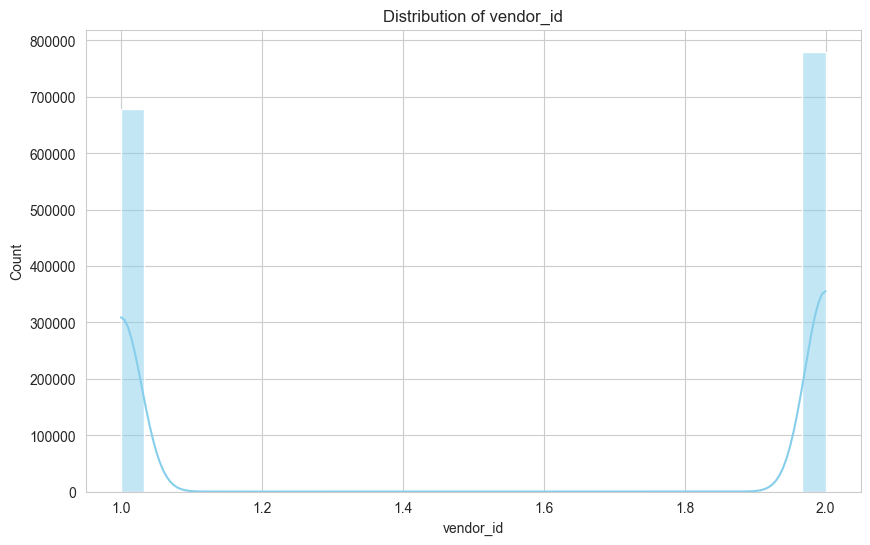

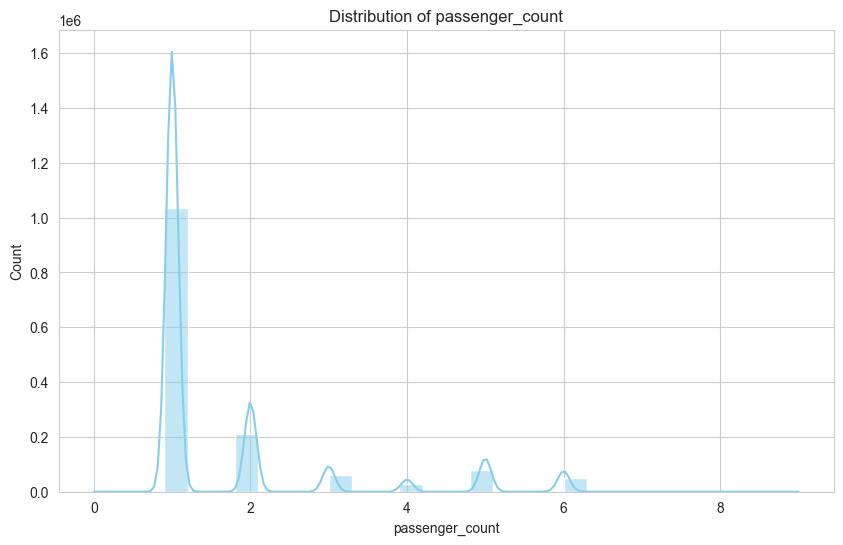

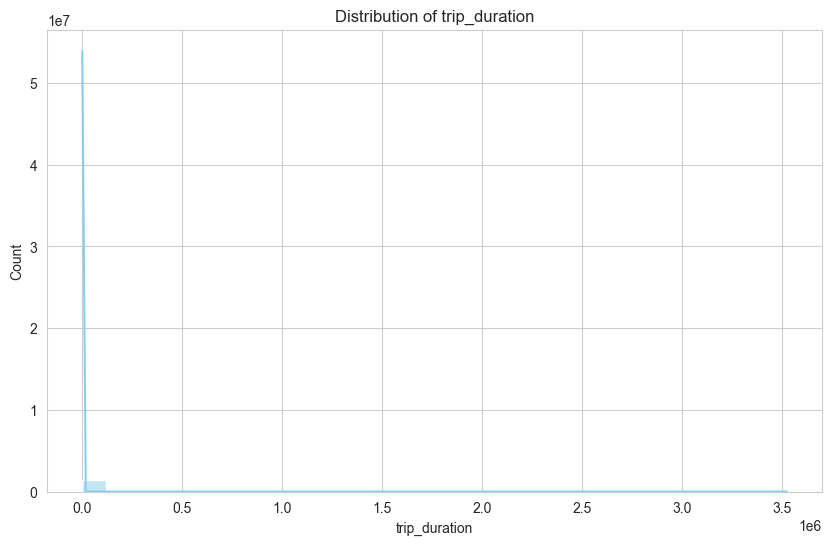

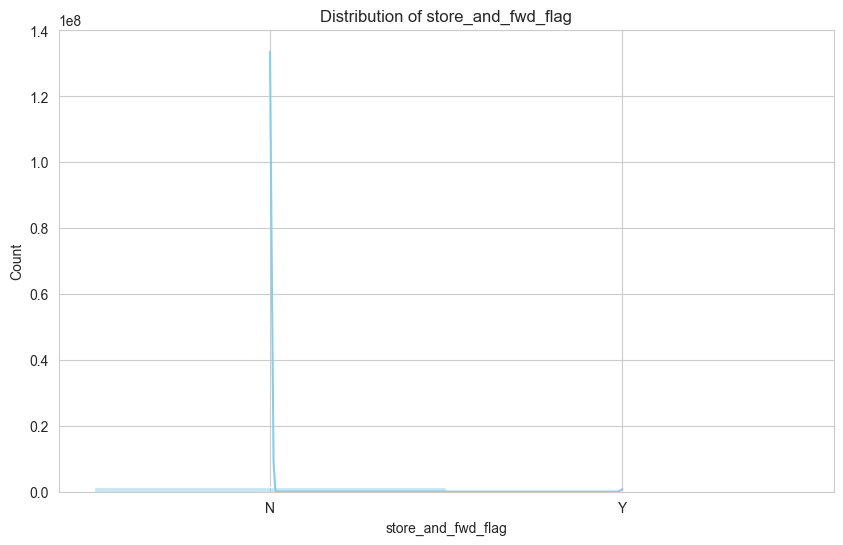

In [92]:
hist_plot_list = ["vendor_id","passenger_count","trip_duration","store_and_fwd_flag"]

output_dir = "./Plots/Plots[1]/"
for column in hist_plot_list:
    plt.figure(figsize=(10, 6))
    sns.histplot(x=df_copy[column], bins=30, color="skyblue", edgecolor=None, kde=True)
    plt.title(f"Distribution of {column}")
    
    plot_path = os.path.join(output_dir, f"{column}_distribution.png")
    plt.savefig(plot_path)
    
    plt.show()

Trip Duration and Trip Distance Outlier Detection and Removal

In [93]:
# Calculate the distance between pickup and dropoff locations using Haversine formula
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

df_copy['trip_distance_km'] = haversine_np(df_copy['pickup_longitude'], df_copy['pickup_latitude'], df_copy['dropoff_longitude'], df_copy['dropoff_latitude'])

display(df_copy[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance_km']].head())

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
0,-73.982,40.768,-73.965,40.766,1.498
1,-73.980,40.739,-73.999,40.731,1.804
2,-73.979,40.764,-74.005,40.710,6.381
3,-74.010,40.720,-74.012,40.707,1.485
4,-73.973,40.793,-73.973,40.783,1.188


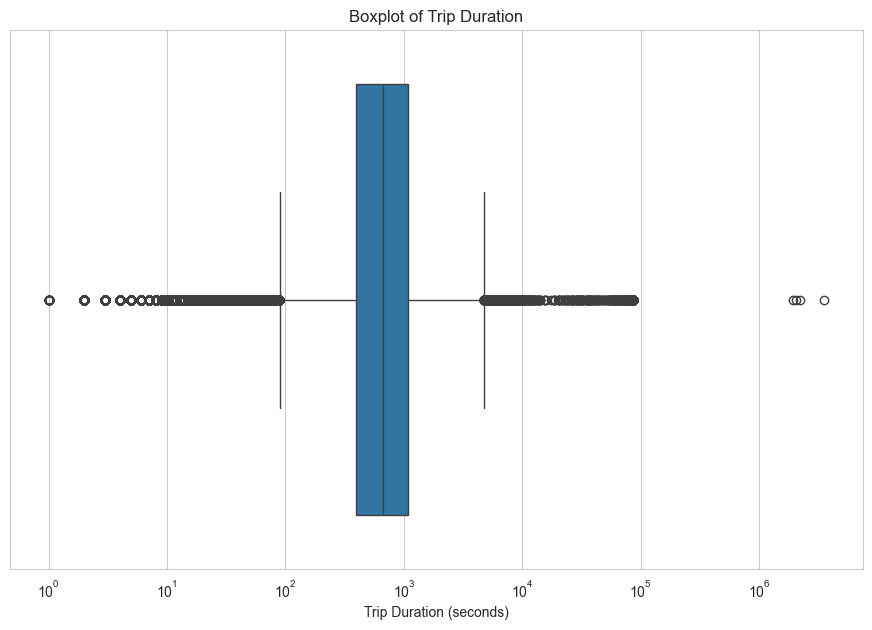

<Figure size 640x480 with 0 Axes>

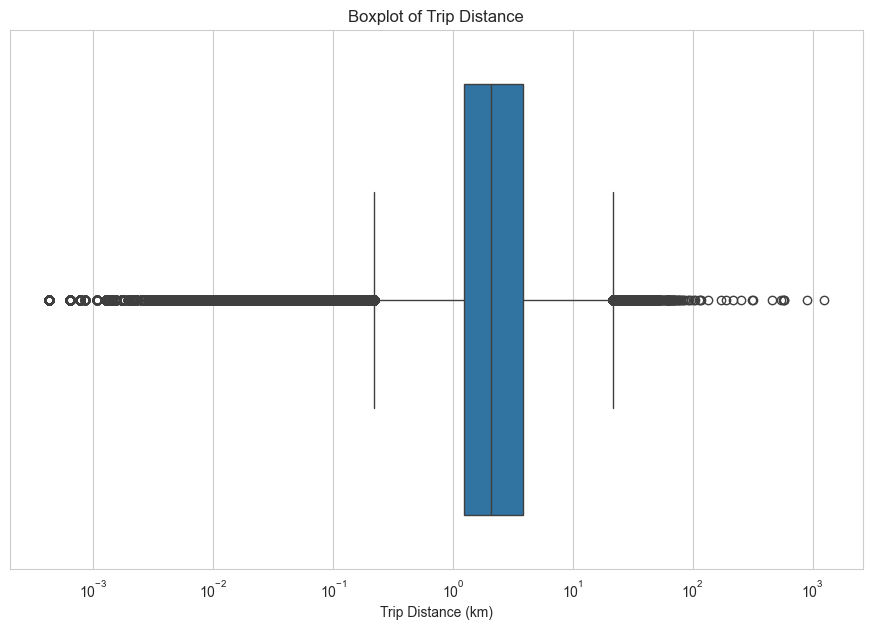

<Figure size 640x480 with 0 Axes>

In [94]:
output_dir = './Plots/Plots[1]'

plot_info = [
    ("trip_duration", "Trip Duration (seconds)", "Boxplot of Trip Duration", "trip_duration_boxplot.png"),
    ("trip_distance_km", "Trip Distance (km)", "Boxplot of Trip Distance", "trip_distance_boxplot.png")
]

sns.set_style('whitegrid')

for column, xlabel, title, filename in plot_info:
    plt.figure(figsize=(11, 7))
    sns.boxplot(x=df_copy[column], log_scale=True)
    plt.xlabel(xlabel)
    plt.title(title)

    plot_path = os.path.join(output_dir, filename)
    plt.savefig(plot_path)

    plt.show()

    plt.clf()

Outlier Removal
- The process of outlier removal was executed in several stages to ensure that the dataset is clean and accurate for further analysis. The key variable used for this process was the relationship between trip duration and trip distance, as visually represented by scatter plots. We performed multiple iterations of outlier detection and removal based on domain knowledge assumptions regarding typical trip duration for various distances. This step-by-step approach ensures that extreme outliers are systematically removed from the dataset while preserving the integrity of normal trip records for further analysis.

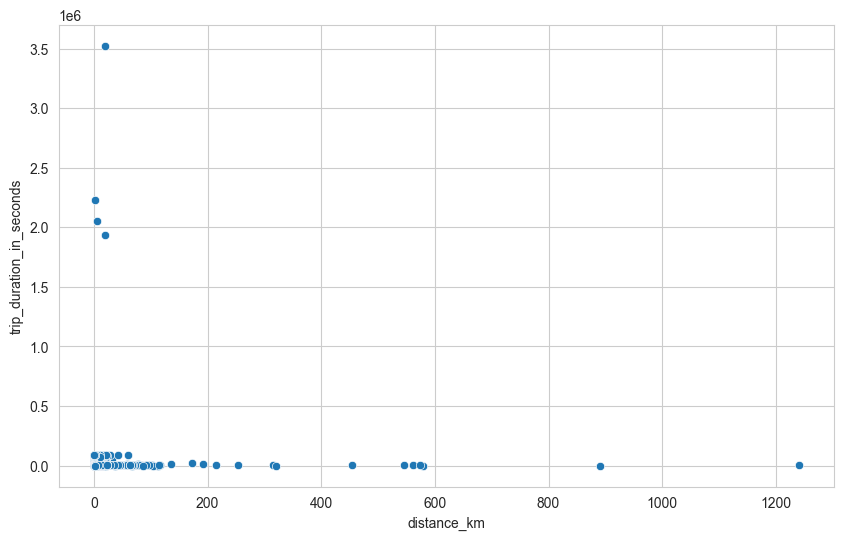

In [95]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_copy["trip_distance_km"],y=df_copy["trip_duration"])
plt.xlabel("distance_km")
plt.ylabel("trip_duration_in_seconds")
plt.savefig('./Plots/Plots[1]/scatterplot.png')
plt.show()

From the graph, we can see several trips with durations exceeding 1.5 million seconds for distances under 50 kilometers. Since it is highly unlikely that trips covering less than 25 km would take more than 8,000 seconds (approximately 2.2 hours), we have set a conservative threshold at 8,000 seconds to flag these outliers.

The same approach was applied to identify other outliers based on the trends observed in the graph

In [96]:
outliers_in_trip_duration_in_seconds = df_copy[(df_copy["trip_duration"] > 8000) & (df_copy["trip_distance_km"] < 25)]

df_cleaned_1 = df_copy.drop(outliers_in_trip_duration_in_seconds.index, axis=0)

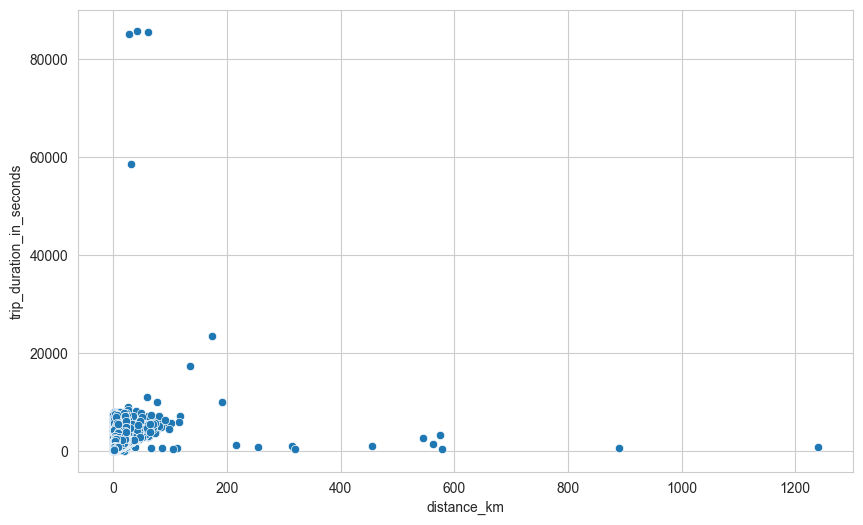

In [97]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_cleaned_1["trip_distance_km"],y=df_cleaned_1["trip_duration"])
plt.xlabel("distance_km")
plt.ylabel("trip_duration_in_seconds")
plt.savefig('./Plots/Plots[1]/scatterplot_cleaned_1.png')
plt.show()

For trips under 200 km, trip durations exceeding 30,000 seconds (approximately 8.3 hours) are likely outliers.

In [98]:
outliers_in_trip_duration_in_seconds_2=df_cleaned_1[(df_cleaned_1["trip_duration"] > 30000) & (df_cleaned_1["trip_distance_km"] < 200)]

In [99]:
df_cleaned_2 = df_cleaned_1.drop(outliers_in_trip_duration_in_seconds_2.index, axis=0)

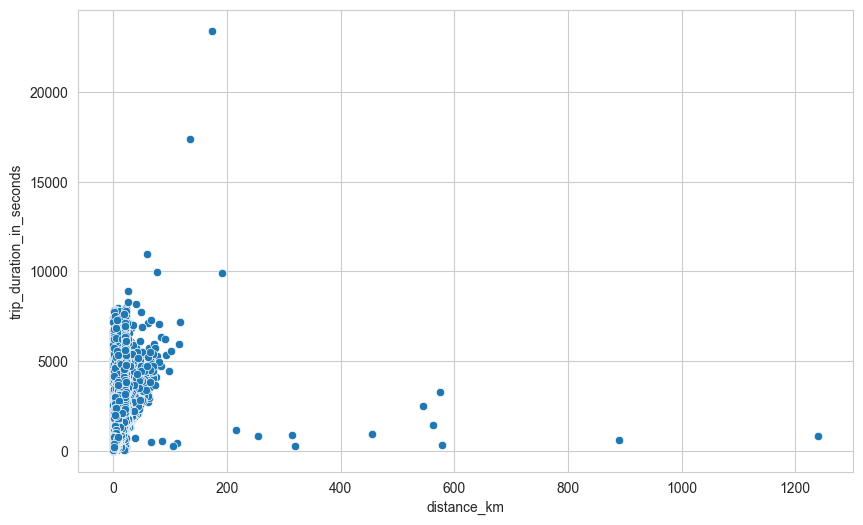

In [100]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_cleaned_2["trip_distance_km"],y=df_cleaned_2["trip_duration"])
plt.xlabel("distance_km")
plt.ylabel("trip_duration_in_seconds")
plt.savefig('./Plots/Plots[1]/scatterplot_cleaned_2.png')
plt.show()

Trips that covered more than 200 km but had a duration of less than 50,000 seconds (around 13.9 hours) are identified as potentially inaccurate and are removed.

In [101]:
outliers_in_trip_duration_in_seconds_3 = df_cleaned_2[(df_cleaned_2["trip_duration"] < 50000) & (df_cleaned_2["trip_distance_km"] > 200)]

In [102]:
df_cleaned_3 = df_cleaned_2.drop(outliers_in_trip_duration_in_seconds_3.index, axis=0)

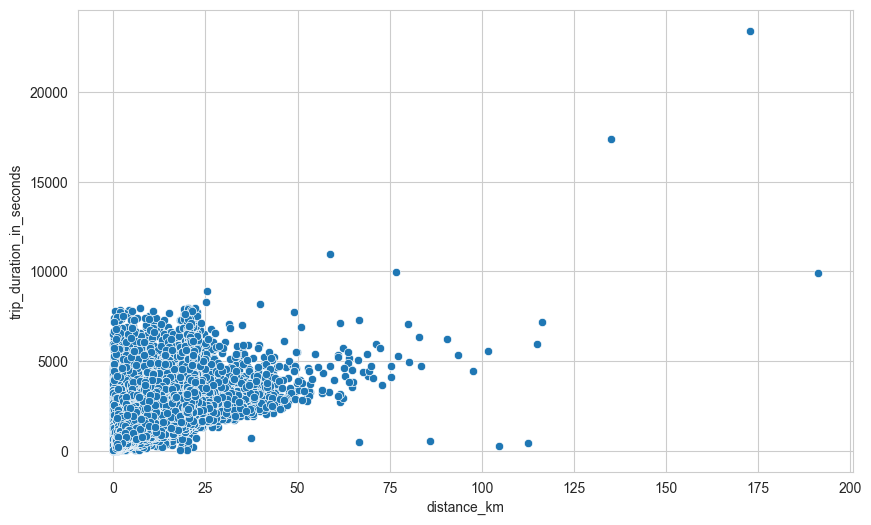

In [103]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_cleaned_3["trip_distance_km"],y=df_cleaned_3["trip_duration"])
plt.xlabel("distance_km")
plt.ylabel("trip_duration_in_seconds")
plt.savefig('./Plots/Plots[1]/scatterplot_cleaned_3.png')
plt.show()

Trips with a `trip_distance_km` of zero but a non-zero `trip_duration` were flagged as outliers, since these records likely represent data entry errors or issues with GPS

In [104]:
outliers_in_trip_duration_in_seconds_4=df_cleaned_3[(df_cleaned_3["trip_duration"] > 0) & (df_cleaned_3["trip_distance_km"] == 0)]

In [105]:
df_cleaned_4 = df_cleaned_3.drop(outliers_in_trip_duration_in_seconds_4.index, axis=0)

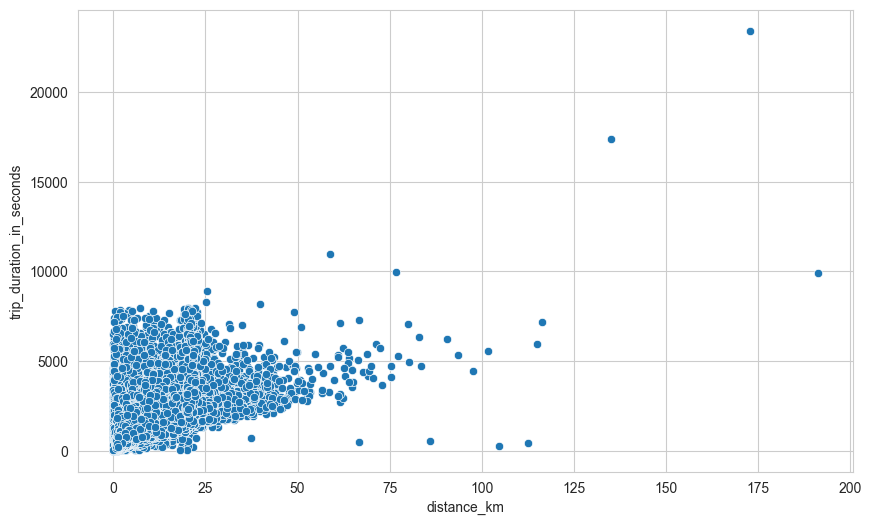

In [106]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_cleaned_4["trip_distance_km"],y=df_cleaned_4["trip_duration"])
plt.xlabel("distance_km")
plt.ylabel("trip_duration_in_seconds")
plt.show()

This is now the final scatter plot with outliers removed with respect to distance_km and trip_duration_in_seconds.

In [107]:
display(df_cleaned_4)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance_km
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,1.498
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,1.804
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,6.381
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,1.485
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,1.188
...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982,40.746,-73.995,40.740,N,778,1.224
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.001,40.747,-73.970,40.797,N,655,6.046
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959,40.769,-74.004,40.707,N,764,7.820
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982,40.749,-73.975,40.757,N,373,1.092


Trip Speed Outlier Detection and Removal
- Calculated the speed of each trip in kilometers per hour (km/h) by dividing the `trip distance` (in kilometers) by the `trip duration` (converted from seconds to hours). This metric helps identify trips with implausibly high or low speeds.
    - A boxplot was generated to visualize the distribution of trip speeds, allowing us to identify extreme outliers.
    - The x-axis was displayed on a logarithmic scale to capture a wide range of speeds, as some trips might exhibit unusually high or low values.

- Z-Score Calculation for Outlier Detection:
    - Identify and remove extreme speed outliers, we employed the Z-score method, which measures the number of standard deviations a data point is from the mean.
    - Z-scores were calculated for the speed_kmh column using the stats.zscore() function.


In [108]:
df_cleaned_4['speed_kmh'] = df_cleaned_4['trip_distance_km'] / (df_cleaned_4['trip_duration'] / 3600)
display(df_cleaned_4[['trip_distance_km', 'trip_duration', 'speed_kmh']].head())

,trip_distance_km,trip_duration,speed_kmh
0,1.498,455,11.849
1,1.804,663,9.798
2,6.381,2124,10.815
3,1.485,429,12.458
4,1.188,435,9.830


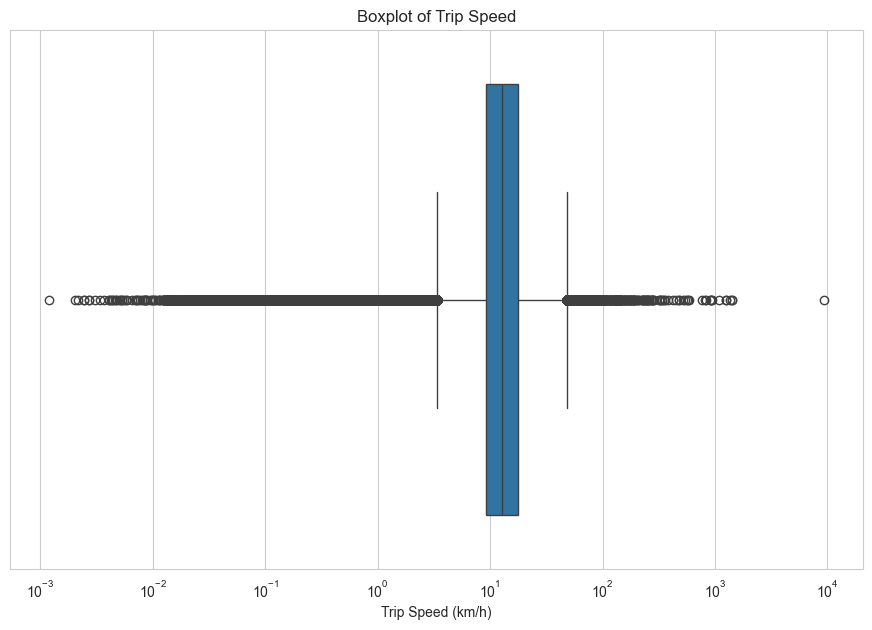

<Figure size 640x480 with 0 Axes>

In [109]:
plt.figure(figsize=(11, 7))
sns.boxplot(
    x=df_cleaned_4["speed_kmh"],
    log_scale=True
)

plt.xlabel('Trip Speed (km/h)')
plt.title('Boxplot of Trip Speed')
plt.savefig('./Plots/Plots[1]/trip_speed_boxplot.png')
plt.show()
plt.clf()

In [110]:
from scipy import stats

# Calculate Z-scores for the speed_kmh column
df_cleaned_4['z_score'] = stats.zscore(df_cleaned_4['speed_kmh'])

# Define the threshold for identifying outliers
z_threshold = 3

# Filter out the outliers in place
df_cleaned_4 = df_cleaned_4[df_cleaned_4['z_score'].abs() <= z_threshold]

# Drop the z_score column as it's no longer needed
df_cleaned_4 = df_cleaned_4.drop(columns=['z_score'])

df_cleaned_4

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance_km,speed_kmh
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,1.498,11.849
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,1.804,9.798
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,6.381,10.815
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,1.485,12.458
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,1.188,9.830
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982,40.746,-73.995,40.740,N,778,1.224,5.665
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.001,40.747,-73.970,40.797,N,655,6.046,33.230
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959,40.769,-74.004,40.707,N,764,7.820,36.847
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982,40.749,-73.975,40.757,N,373,1.092,10.538


Passenger Count Outlier Detection and Removal

In [111]:
df_cleaned_4.passenger_count.value_counts()

passenger_count
1    1025583
2     208702
5      77379
3      59439
6      47801
4      28156
0         49
7          2
Name: count, dtype: int64

Filtered out trips where the `passenger_count` was 0, as it is not reasonable for a taxi trip to have zero passengers. Such entries were likely errors or anomalies in the data.

In [112]:
df_cleaned_4 = df_cleaned_4[df_cleaned_4['passenger_count'] != 0]
df_cleaned_4 = df_cleaned_4[df_cleaned_4['passenger_count'] <= 6]

df_cleaned_4.passenger_count.value_counts()

passenger_count
1    1025583
2     208702
5      77379
3      59439
6      47801
4      28156
Name: count, dtype: int64

Save cleaned dataframe to new .csv file.

In [113]:
df_cleaned_4.to_csv('./nyc_taxis/nyc_taxi_cleaned.csv', index=False)

### Question 2: Feature Engineering

Generate additional columns for at least these features (but you’re welcome to add more!):
- Distance of trip
- Day of week
- Average speed of trip

Note: Distance of trip and average speed of trip were already calculated in the Data Cleaning steps in Question 1.

In [114]:
df = pd.read_csv('./nyc_taxis/nyc_taxi_cleaned.csv')

display(df[['trip_distance_km', 'speed_kmh']])

,trip_distance_km,speed_kmh
0,1.498,11.849
1,1.804,9.798
2,6.381,10.815
3,1.485,12.458
4,1.188,9.830
...,...,...
1447055,1.224,5.665
1447056,6.046,33.230
1447057,7.820,36.847
1447058,1.092,10.538


In [115]:
# Convert pickup and dropoff datetime columns to datetime objects
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Extract day of the week (0=Monday, 6=Sunday)
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

# Map integer values to day names
day_of_week_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
df['day_of_week_str'] = df['day_of_week'].map(day_of_week_map)

# Additional feature: Extract hour of the day
df['pickup_hour'] = df['pickup_datetime'].dt.hour

# Additional feature: Time of day (morning, afternoon, evening)
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_of_day'] = df['pickup_hour'].apply(time_of_day)


# Additional feature: trip duration in minutes
df['trip_duration_min'] = df['trip_duration'] / 60

display(df.head())

df.to_csv('./nyc_taxis/nyc_taxi_cleaned_with_features.csv', index=False)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance_km,speed_kmh,day_of_week,day_of_week_str,pickup_hour,time_of_day,trip_duration_min
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,1.498,11.849,0,Monday,17,Evening,7.583
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,1.804,9.798,6,Sunday,0,Night,11.050
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,6.381,10.815,1,Tuesday,11,Morning,35.400
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,1.485,12.458,2,Wednesday,19,Evening,7.150
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,1.188,9.830,5,Saturday,13,Afternoon,7.250


### Question 3: Time-based

**[3.1]** Which day of the week is the most popular? Show plots to motivate your answer.

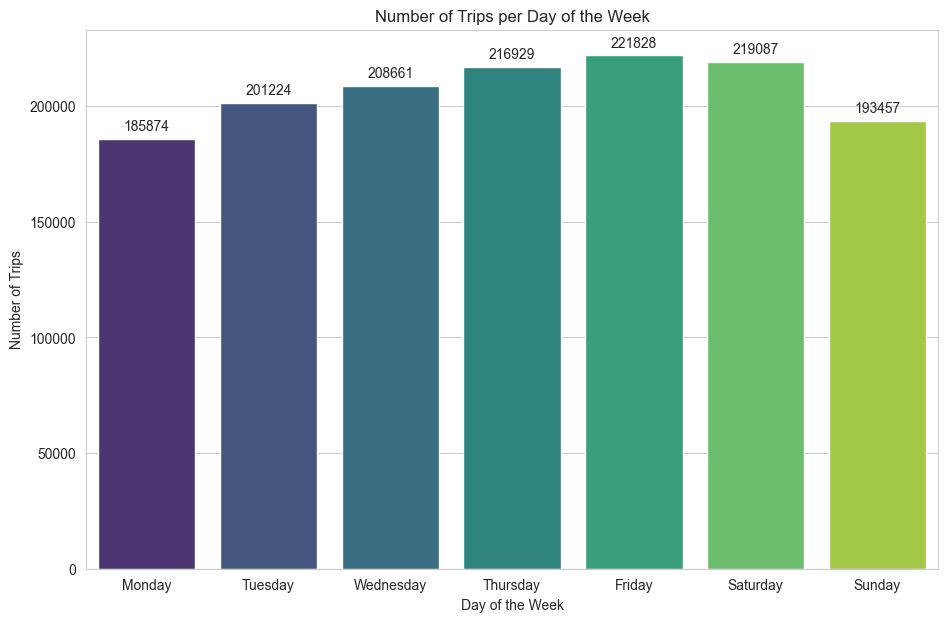

<Figure size 640x480 with 0 Axes>

In [116]:
df = pd.read_csv('./nyc_taxis/nyc_taxi_cleaned_with_features.csv')
day_of_week_counts = df['day_of_week'].value_counts().sort_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(11, 7))
ax = sns.barplot(x=days, y=day_of_week_counts, hue=days, dodge=False, estimator="sum", palette='viridis')

# Add the total above each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Day of the Week')
plt.savefig('./Plots/Plots[3]/Plots[3.1]/num_of_trips_per_day_of_the_week.png')
plt.show()
plt.clf()

**[3.2]** What hour of the day is the most popular on each day? Plot a distribution of the hours and make observations and give possible suggestions for why the data looks like it does.

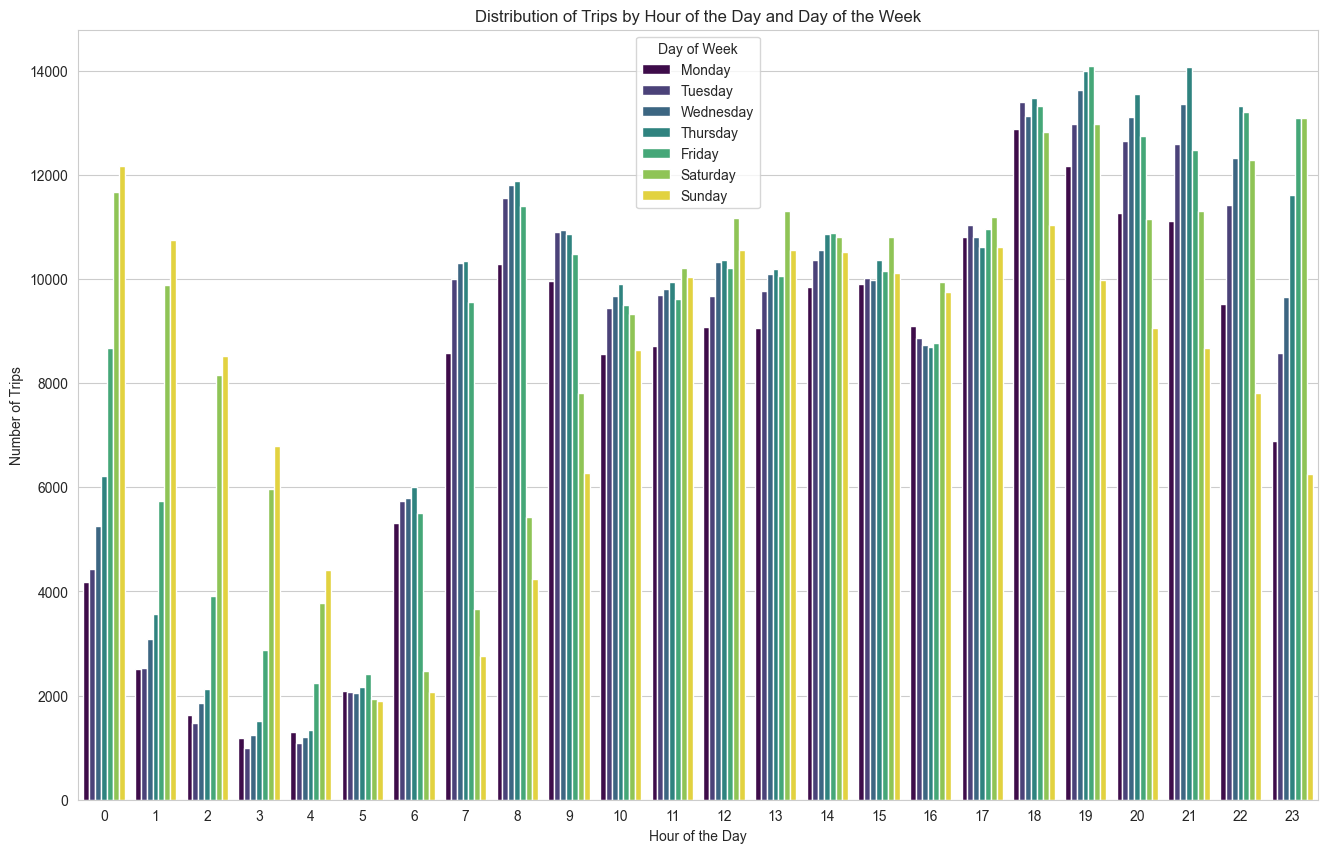

The most popular hour overall is: 18


<Figure size 640x480 with 0 Axes>

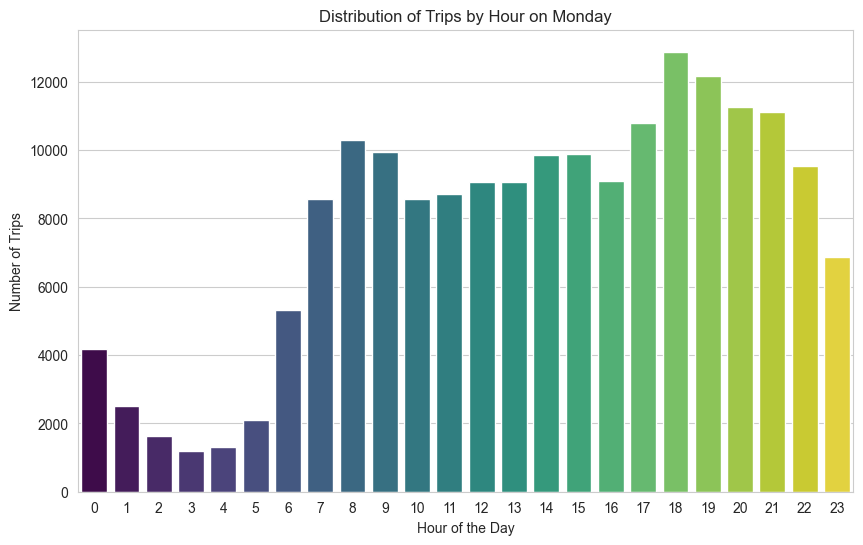

The most popular hour on Monday is: 18


<Figure size 640x480 with 0 Axes>

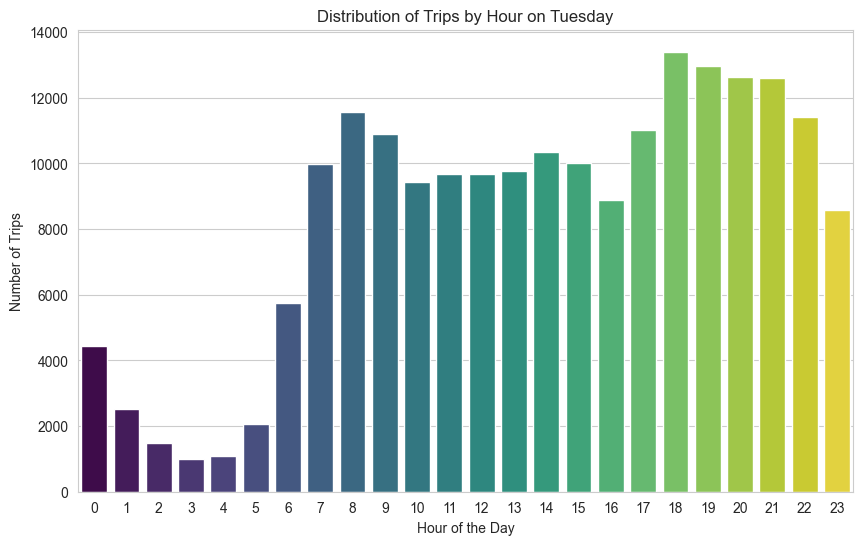

The most popular hour on Tuesday is: 18


<Figure size 640x480 with 0 Axes>

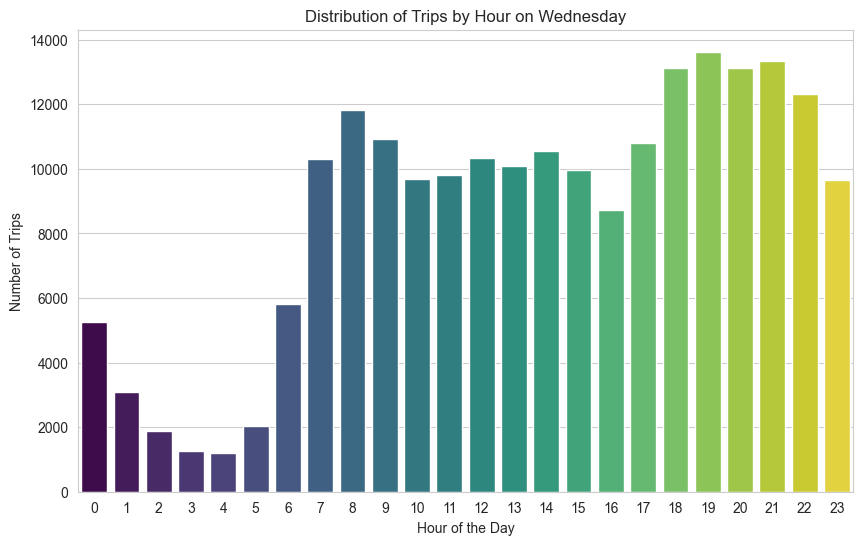

The most popular hour on Wednesday is: 19


<Figure size 640x480 with 0 Axes>

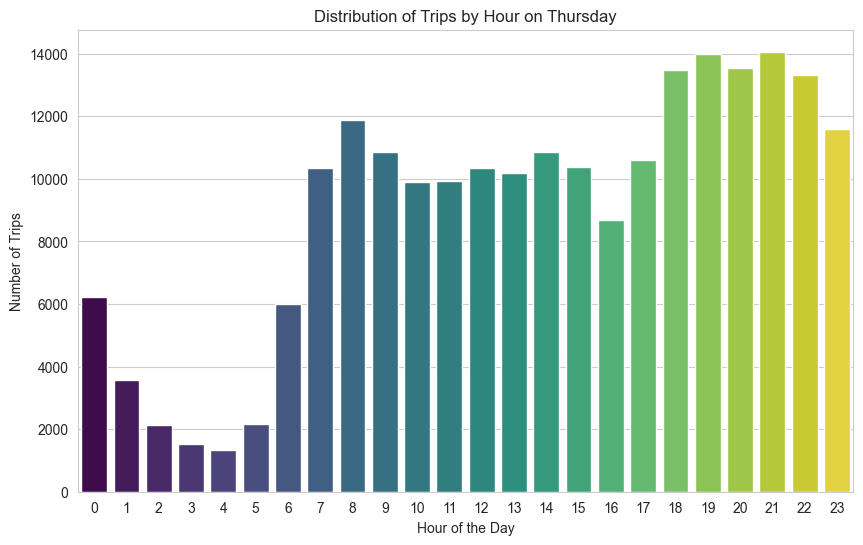

The most popular hour on Thursday is: 21


<Figure size 640x480 with 0 Axes>

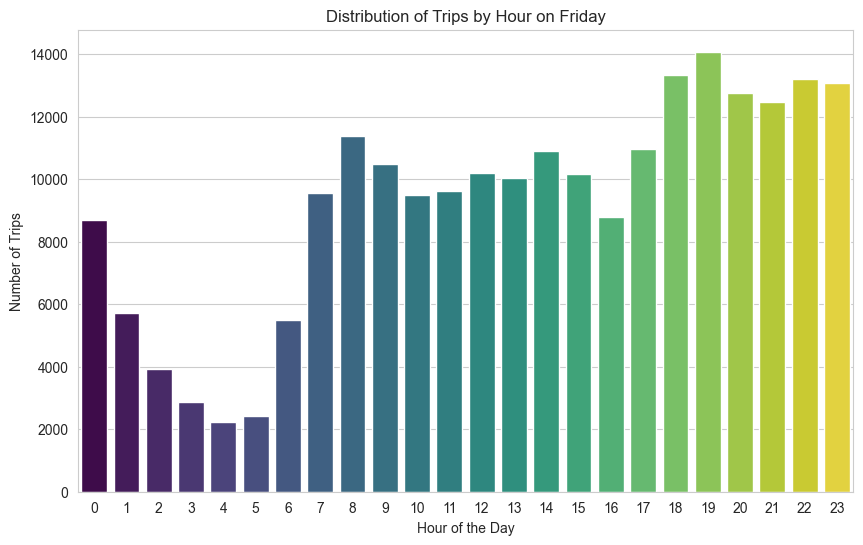

The most popular hour on Friday is: 19


<Figure size 640x480 with 0 Axes>

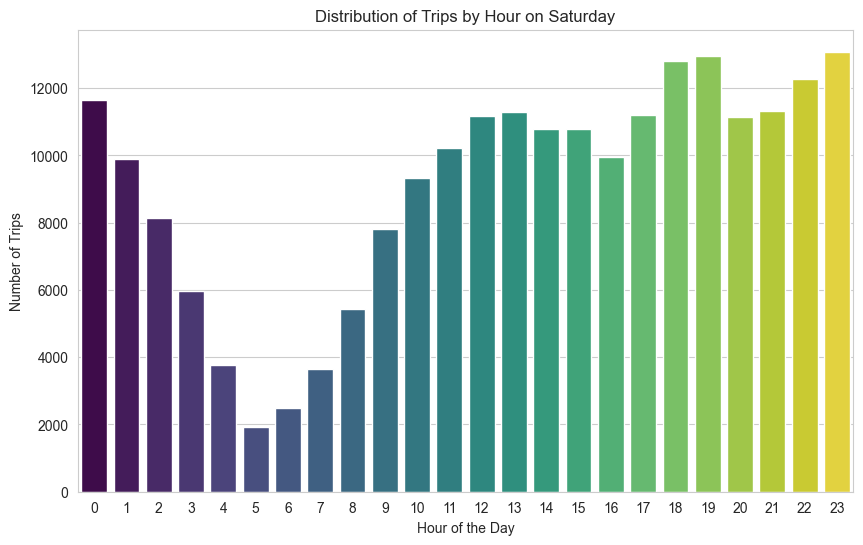

The most popular hour on Saturday is: 23


<Figure size 640x480 with 0 Axes>

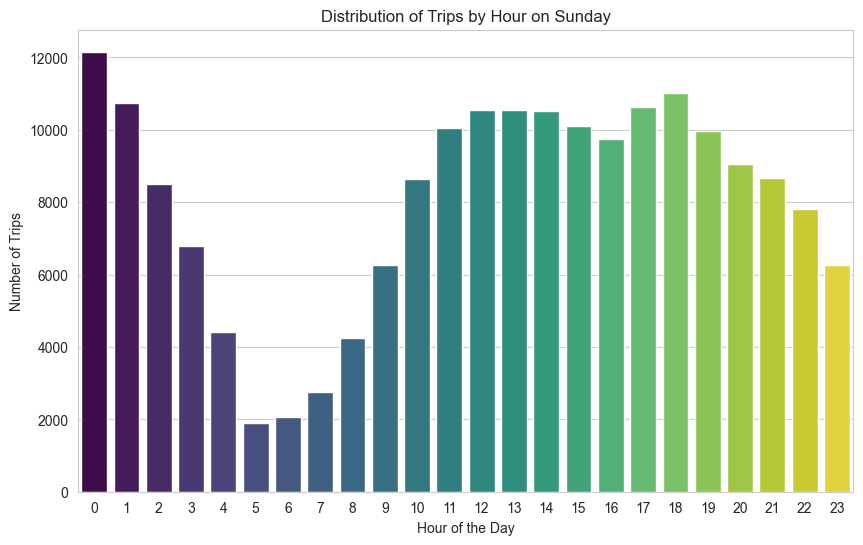

The most popular hour on Sunday is: 0


<Figure size 640x480 with 0 Axes>

In [117]:
output_folder = './Plots/Plots[3]/Plots[3.2]'
os.makedirs(output_folder, exist_ok=True)

# Define the days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Overall distribution of trips by hour and day of the week
plt.figure(figsize=(16, 10))
sns.countplot(data=df, x='pickup_hour', hue='day_of_week', palette='viridis')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trips by Hour of the Day and Day of the Week')
plt.legend(title='Day of Week', labels=days)
plt.savefig(os.path.join(output_folder, 'trips_by_hour_of_the_day_and_day_of_the_week.png'))
plt.show()
plt.clf()

# Print the most popular hour overall
most_popular_hour_overall = df['pickup_hour'].mode()[0]
print(f'The most popular hour overall is: {most_popular_hour_overall}')

# Individual plots for each day of the week
for i, day in enumerate(days):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df[df['day_of_week'] == i], x='pickup_hour', hue='pickup_hour', palette='viridis', legend=False)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title(f'Distribution of Trips by Hour on {day}')
    plt.savefig(os.path.join(output_folder, f'trips_by_hour_on_{day.lower()}.png'))
    plt.show()
    plt.clf()
    
    # Print the most popular hour for each day
    most_popular_hour = df[df['day_of_week'] == i]['pickup_hour'].mode()[0]
    print(f'The most popular hour on {day} is: {most_popular_hour}')

**[3.3]** Investigate the differences between weekdays and weekends. What would account for this? 

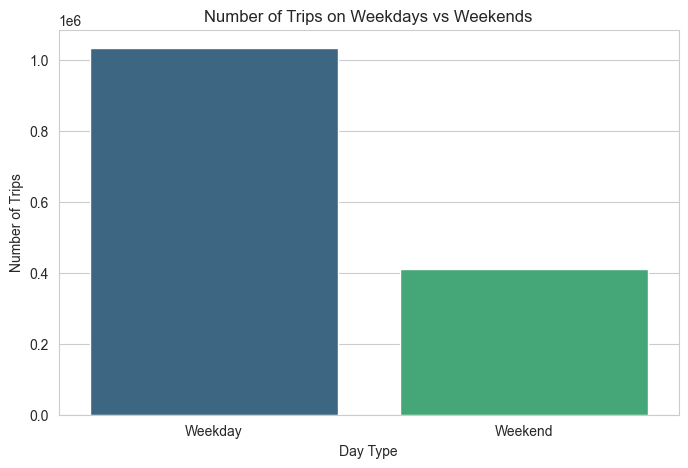

<Figure size 640x480 with 0 Axes>

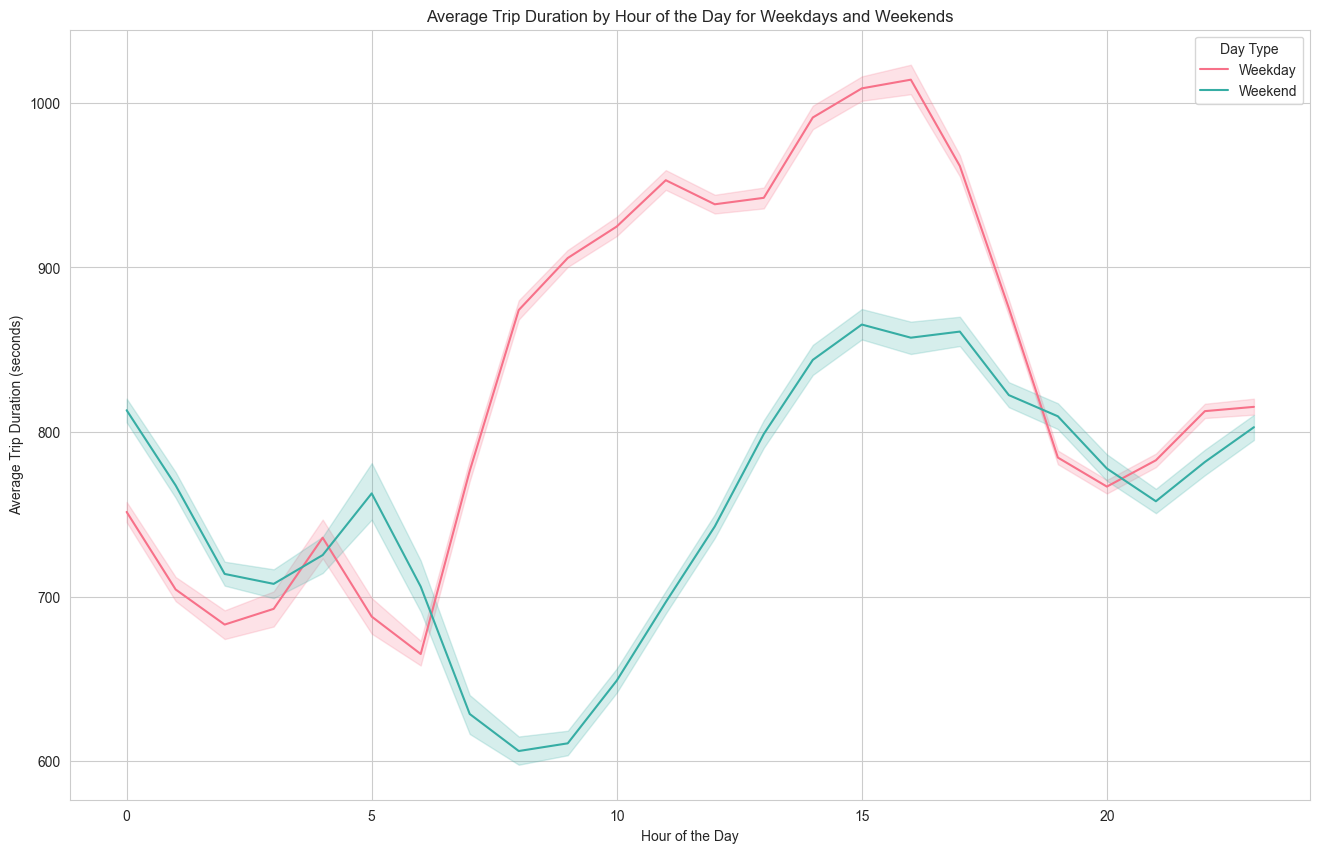

<Figure size 640x480 with 0 Axes>

In [118]:
# Create a new column indicating whether the day is a weekend
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Compare trips on weekdays vs weekends
weekend_vs_weekday_counts = df['is_weekend'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=['Weekday', 'Weekend'], y=weekend_vs_weekday_counts, hue=['Weekday', 'Weekend'], dodge=False, estimator="sum", palette='viridis')
plt.xlabel('Day Type')
plt.ylabel('Number of Trips')
plt.title('Number of Trips on Weekdays vs Weekends')
plt.savefig('./Plots/Plots[3]/Plots[3.3]/num_trips_on_weekdays_vs_weekends.png')
plt.show()
plt.clf()

# Line plot for average trip duration on weekdays vs weekends
plt.figure(figsize=(16, 10))
palette = sns.color_palette("husl", 2)
sns.lineplot(data=df[df['is_weekend'] == 0], x='pickup_hour', y='trip_duration', label='Weekday', color=palette[0])
sns.lineplot(data=df[df['is_weekend'] == 1], x='pickup_hour', y='trip_duration', label='Weekend', color=palette[1])
plt.xlabel('Hour of the Day')
plt.ylabel('Average Trip Duration (seconds)')
plt.title('Average Trip Duration by Hour of the Day for Weekdays and Weekends')
plt.legend(title='Day Type')
plt.savefig('./Plots/Plots[3]/Plots[3.3]/avg_trip_duration_by_hour_for_weekdays_and_weekends.png')
plt.show()
plt.clf()

The bar plot visualizes the number of trips on weekdays compared to weekends. The data shows that significantly more trips occur on weekdays than on weekends. There are several factors that could account for this difference:

1. **Work and School Commutes**:
   - Weekdays typically have higher trip volumes due to regular work and school commutes. People travel to and from work, school, and other routine activities, contributing to the increased number of trips. The structured nature of weekdays means that more people are out and about during set times, driving up the number of trips.

2. **Business Activity**:
   - Many businesses operate primarily during weekdays, which results in more trips for meetings, deliveries, and other business-related activities. This business activity contributes to higher trip counts on weekdays compared to weekends, when business operations are reduced.

3. **Leisure vs. Routine Travel**:
   - Weekends are generally reserved for leisure activities, which may not require as many short or frequent trips as weekdays. People may prefer to stay home or engage in fewer activities, leading to a decrease in overall transportation demand. This contrasts with weekdays where routine activities drive consistent trip demands.

4. **Public Transportation and Ride-Hailing Services**:
   - The availability and demand for public transportation and ride-hailing services might differ between weekdays and weekends. On weekdays, these services are often used more for commuting purposes, whereas on weekends, people might use alternative transportation options or have different travel patterns, impacting the number of trips.

**[3.4]** Look at how these patterns change on the major holidays (do they change?). Look at the following: St. Patrick’s Day, Easter, Memorial Day, Valentine’s Day, Martin Luther King Day. Make sure you use the correct dates for these for the relevant year.

Steps/Explanation for [3.4] Analysis of Trip Patterns on Major Holidays

Objective: Analyze how trip patterns change on major holidays compared to regular days. The holidays of interest are St. Patrick’s Day, Easter, Memorial Day, Valentine’s Day, and Martin Luther King Day in 2016. Specifically, we want to determine if there are significant differences in the hourly distribution of trips and cumulative trip patterns on these holidays.

1. Identify Major Holidays in the Dataset:
    - Define the dates of the major holidays in 2016 and convert these dates to datetime objects.
    - Process the dataset to include a new column, `is_holiday`, which indicates whether a trip occurred on a major holiday.

2. Overall Comparison of Trip Counts:
    - Create a bar plot to compare the total number of trips on holidays versus non-holidays.

3. Hourly Distribution of Trips on Each Holiday:
    - For each holiday, filter the dataset to include only trips that occurred on that specific holiday.
    - Calculate the date exactly one week before the holiday and ensure it is not another major holiday.
    - Filter the dataset to include trips that occurred one week before the holiday.
    - Create a combined count plot to compare the hourly distribution of trips on the holiday versus one week before.

4. Cumulative Distribution Function (CDF) Analysis:
    - Plot the Cumulative Distribution Function (CDF) for trips on each holiday and compare it with the CDF for trips on a regular day one week before.

5. Average Trip Duration Analysis:
    - Create a line plot for average trip duration by hour of the day for the holiday and one week before.

6. Holiday vs. Non-Holiday Cumulative Distribution:
    - Plot the Cumulative Distribution Function (CDF) for trips on holidays versus non-holidays.

7. Average Trip Duration on Holidays vs Non-Holidays:
    - Create a line plot for average trip duration by hour of the day for holidays and non-holidays.

Conclusion:
- This multi-faceted approach provides a comprehensive analysis of how trip patterns change on major holidays. By comparing hourly distributions and cumulative distributions, we gain valuable insights into whether holidays significantly affect travel behavior in New York City. These insights could be useful for understanding traffic management, service demand, and urban planning during holidays.


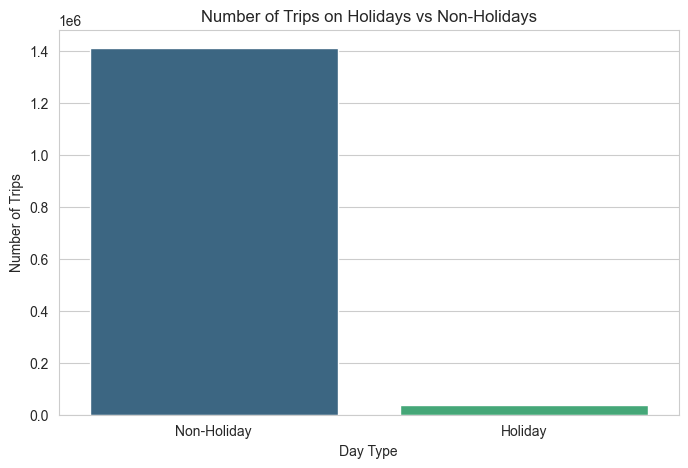

<Figure size 640x480 with 0 Axes>

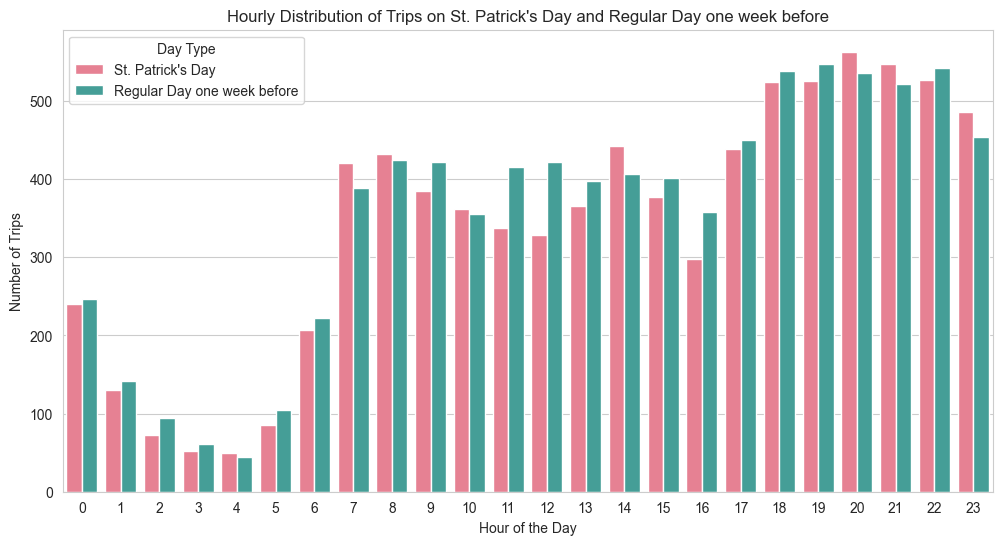

<Figure size 640x480 with 0 Axes>

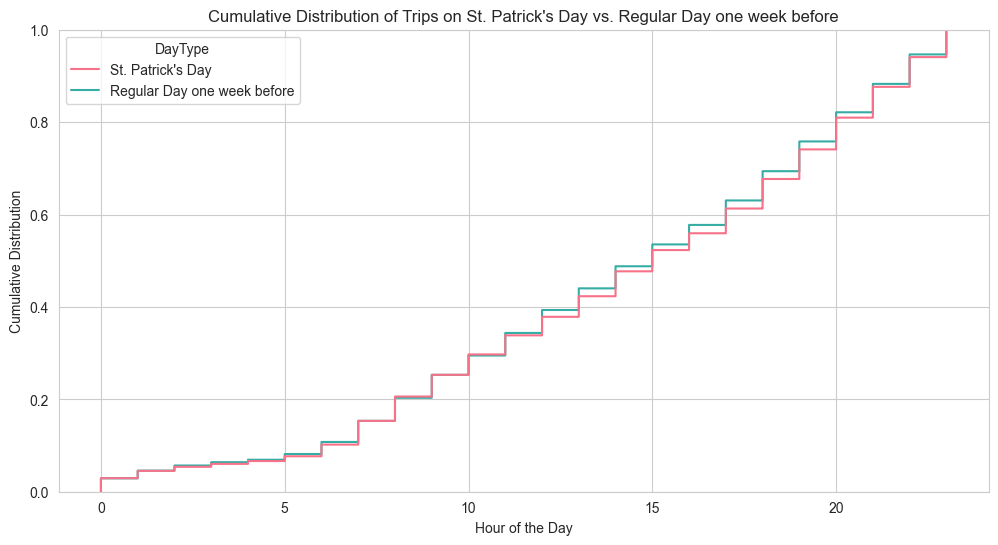

<Figure size 640x480 with 0 Axes>

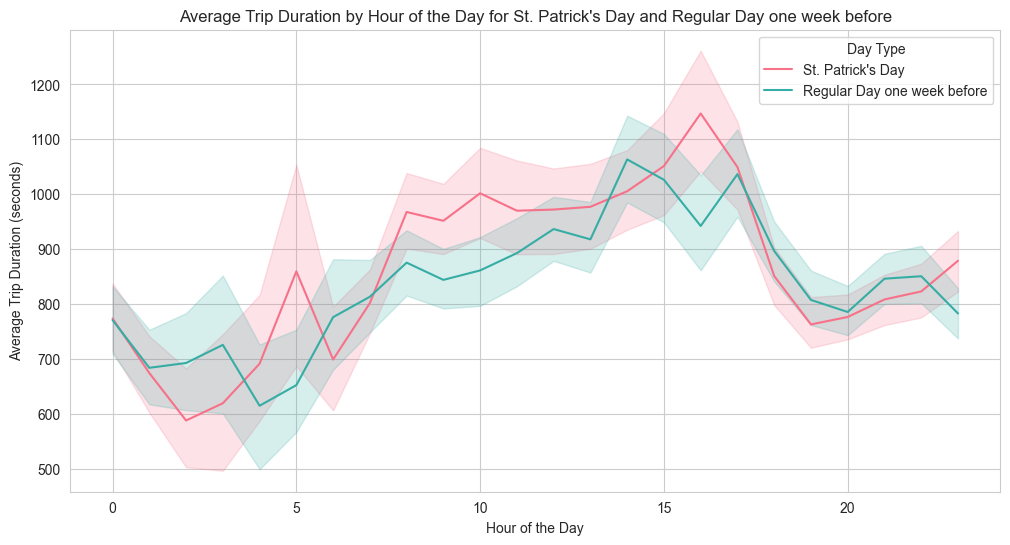

<Figure size 640x480 with 0 Axes>

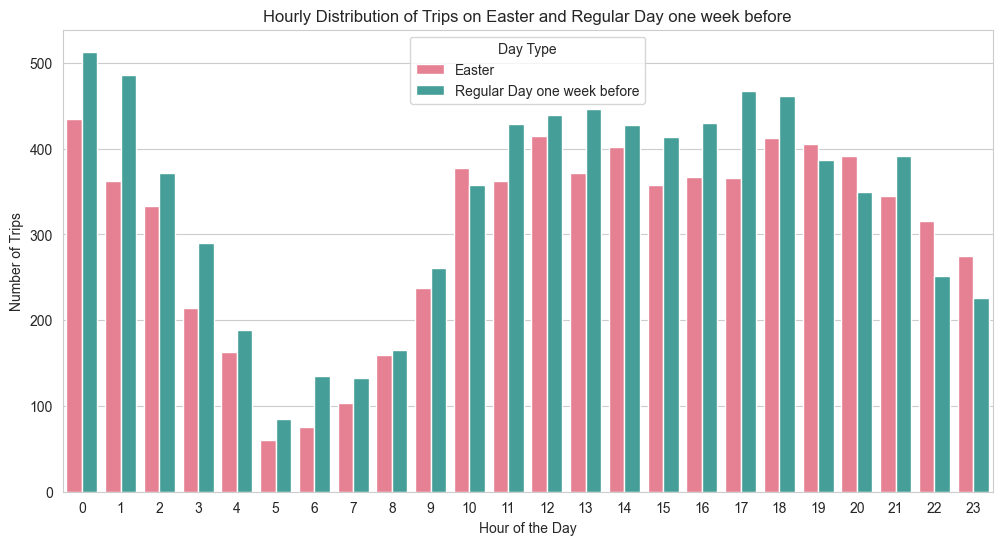

<Figure size 640x480 with 0 Axes>

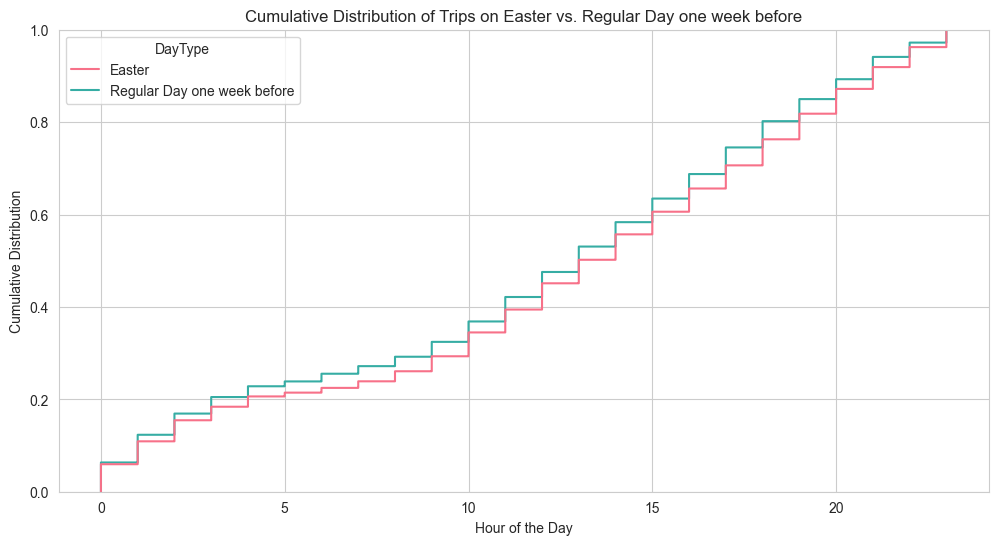

<Figure size 640x480 with 0 Axes>

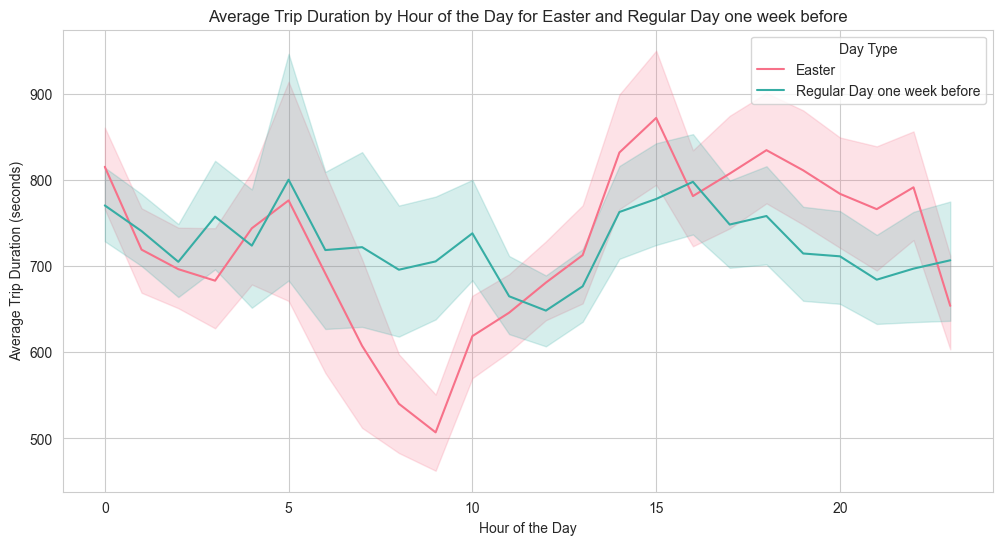

<Figure size 640x480 with 0 Axes>

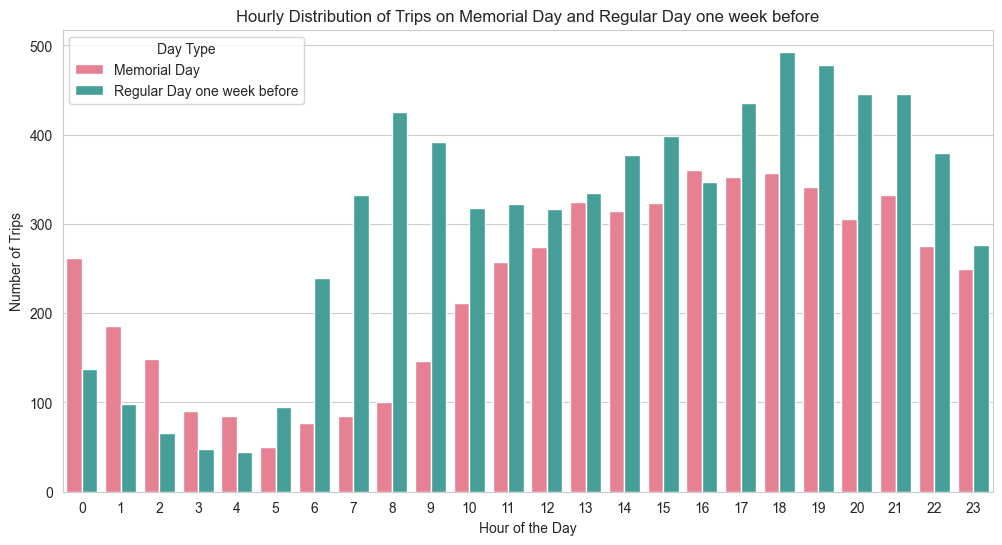

<Figure size 640x480 with 0 Axes>

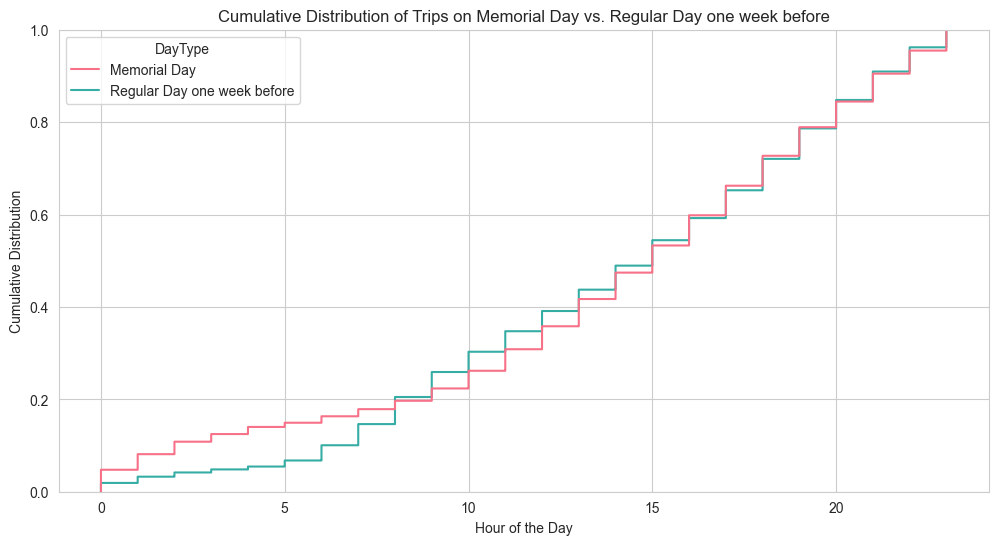

<Figure size 640x480 with 0 Axes>

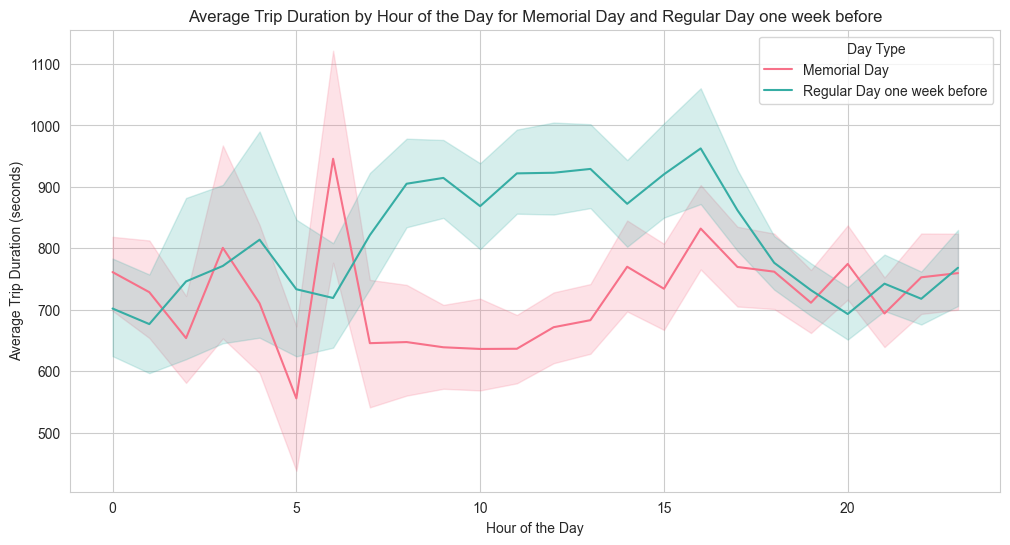

<Figure size 640x480 with 0 Axes>

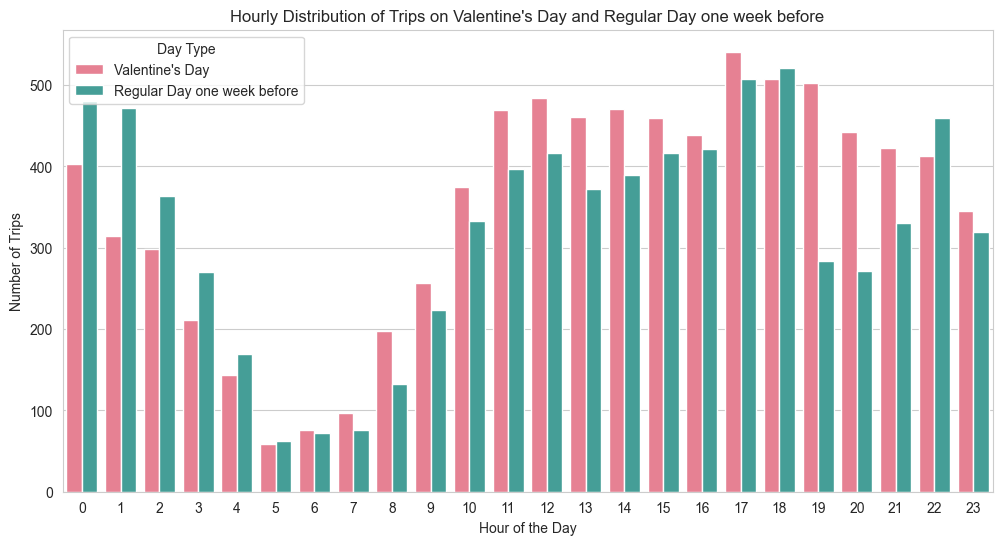

<Figure size 640x480 with 0 Axes>

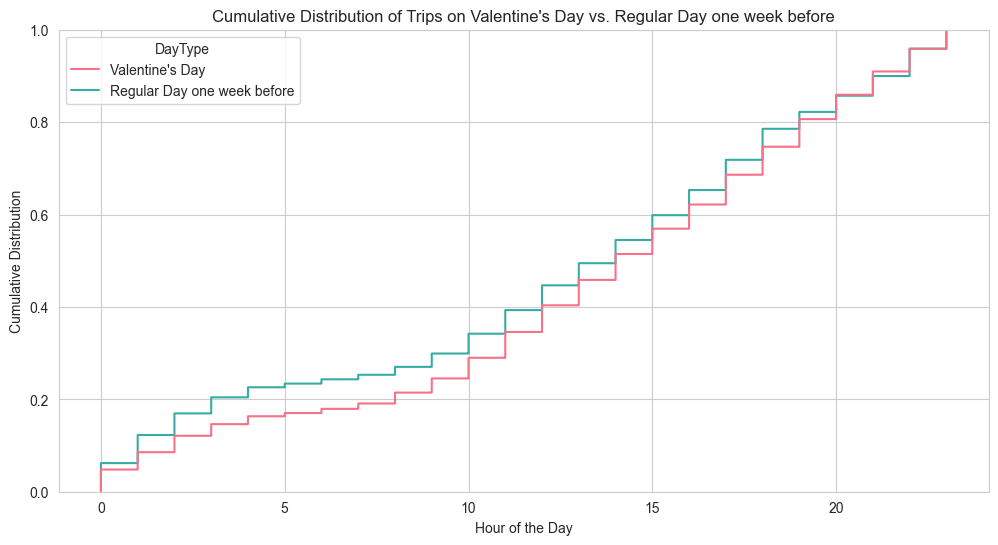

<Figure size 640x480 with 0 Axes>

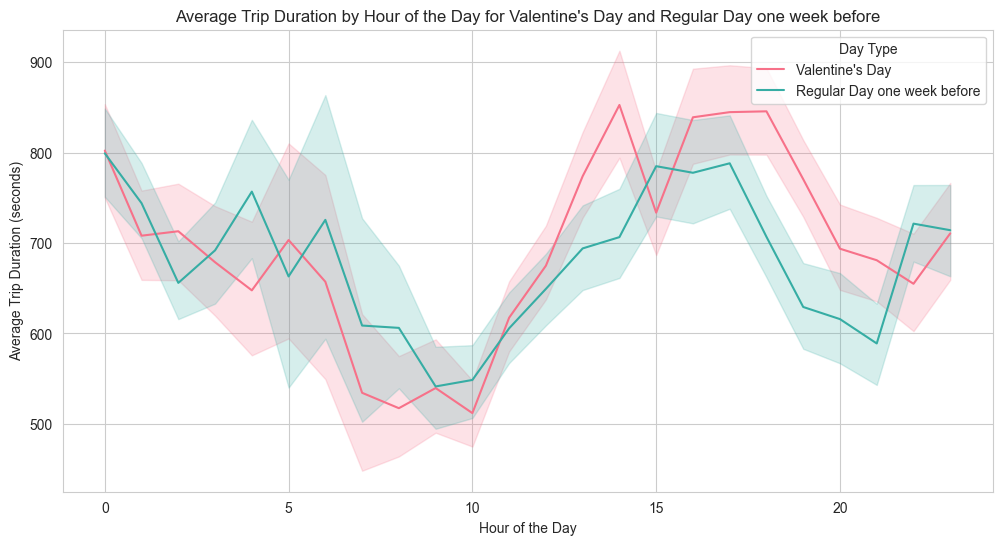

<Figure size 640x480 with 0 Axes>

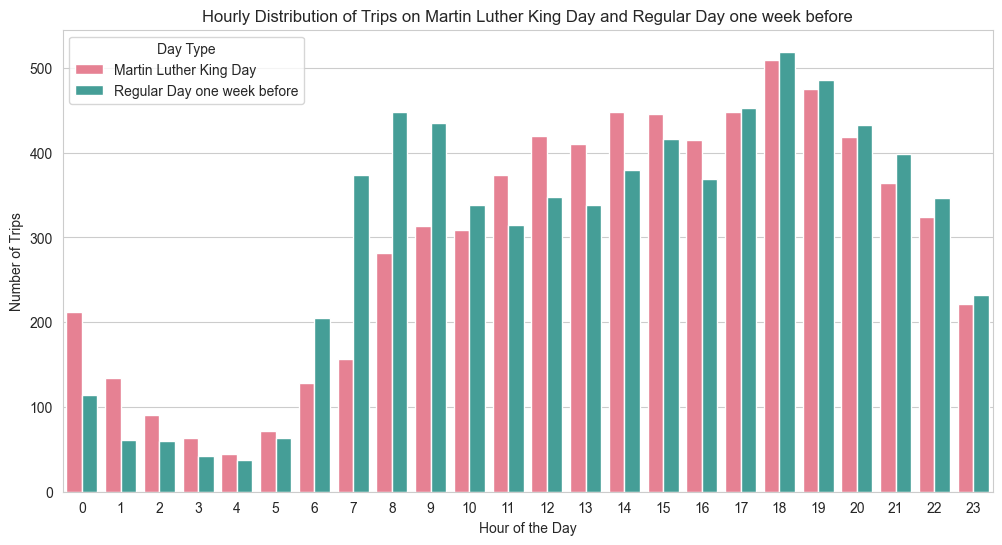

<Figure size 640x480 with 0 Axes>

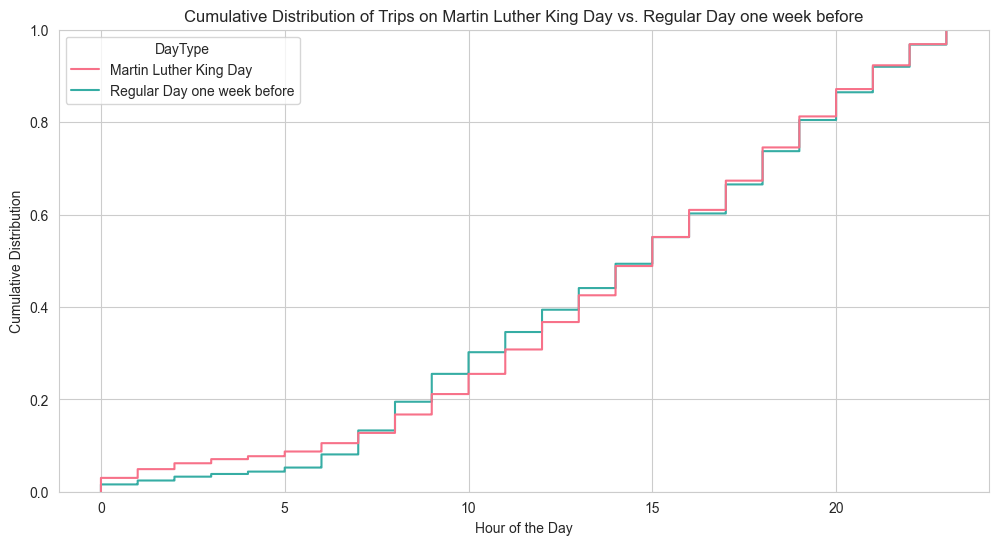

<Figure size 640x480 with 0 Axes>

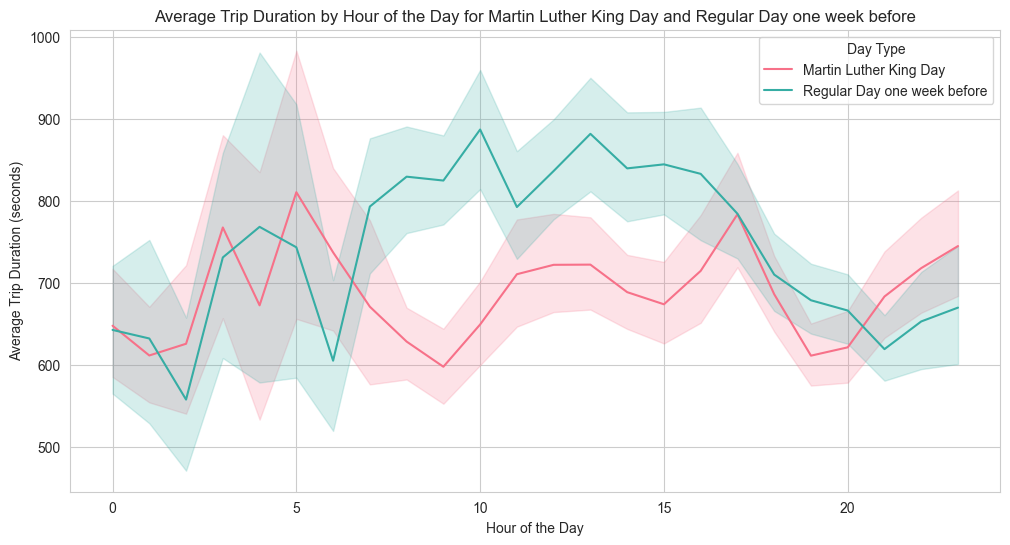

<Figure size 640x480 with 0 Axes>

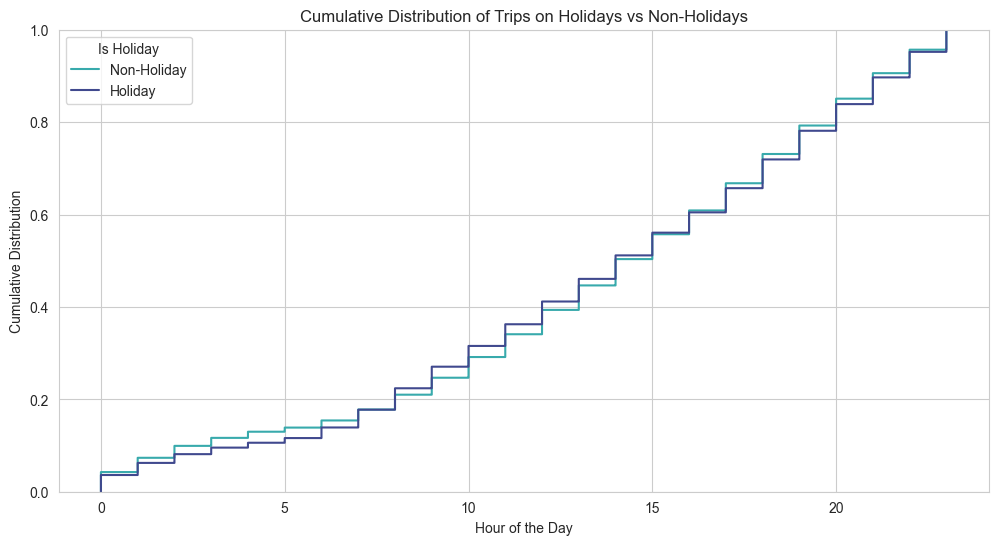

<Figure size 640x480 with 0 Axes>

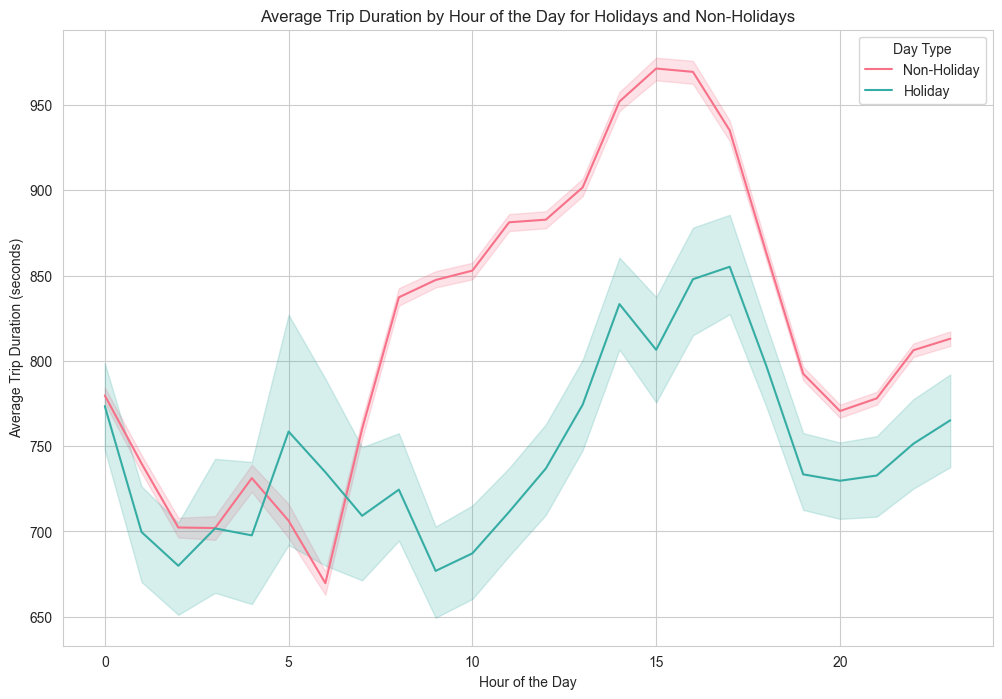

<Figure size 640x480 with 0 Axes>

In [119]:
output_folder = "./Plots/Plots[3]/Plots[3.4]"

# Define major holidays in 2016
holidays_2016 = {
    'St. Patrick\'s Day': '2016-03-17',
    'Easter': '2016-03-27',
    'Memorial Day': '2016-05-30',
    'Valentine\'s Day': '2016-02-14',
    'Martin Luther King Day': '2016-01-18'
}

# Convert holiday dates to datetime objects
holiday_dates = pd.to_datetime(list(holidays_2016.values()))

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Create a new column indicating whether the trip occurred on a major holiday
df['is_holiday'] = df['pickup_datetime'].dt.normalize().isin(holiday_dates)

# Compare trip counts on holidays vs non-holidays
holiday_vs_nonholiday_counts = df['is_holiday'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=['Non-Holiday', 'Holiday'], y=holiday_vs_nonholiday_counts, hue=['Non-Holiday', 'Holiday'], dodge=False, estimator="sum", palette='viridis')
plt.xlabel('Day Type')
plt.ylabel('Number of Trips')
plt.title('Number of Trips on Holidays vs Non-Holidays')
plt.savefig(os.path.join(output_folder, "trips_holidays_vs_nonholidays.png"))
plt.show()
plt.clf()

# Analyze differences during holidays
for holiday, date in holidays_2016.items():
    holiday_data = df[df['pickup_datetime'].dt.date == pd.to_datetime(date).date()]
    
    # Calculate the date exactly one week before
    one_week_before_date = pd.to_datetime(date) - pd.Timedelta(weeks=1)
    
    # Ensure the date one week before is not a major holiday
    while one_week_before_date in holiday_dates:
        one_week_before_date -= pd.Timedelta(weeks=1)
    
    one_week_before_data = df[df['pickup_datetime'].dt.date == one_week_before_date.date()]

    # Combined countplot for holiday and one week before
    plt.figure(figsize=(12, 6))
    palette = sns.color_palette("husl", 2)
    combined_data = pd.concat([holiday_data.assign(DayType=f'{holiday}'), one_week_before_data.assign(DayType='Regular Day one week before')])
    sns.countplot(data=combined_data, x='pickup_hour', hue='DayType', palette=[palette[0], palette[1]])
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title(f'Hourly Distribution of Trips on {holiday} and Regular Day one week before')
    plt.legend(title='Day Type')
    plt.savefig(os.path.join(output_folder, f"{holiday}_vs_regularday_countplot.png"))
    plt.show()
    plt.clf()

    # Cumulative distribution function (CDF)
    combined_data = pd.concat([holiday_data.assign(DayType=holiday), one_week_before_data.assign(DayType='Regular Day one week before')])

    plt.figure(figsize=(12, 6))
    sns.ecdfplot(data=combined_data, x='pickup_hour', hue='DayType', palette=[palette[0], palette[1]])
    plt.xlabel('Hour of the Day')
    plt.ylabel('Cumulative Distribution')
    plt.title(f'Cumulative Distribution of Trips on {holiday} vs. Regular Day one week before')
    plt.savefig(os.path.join(output_folder, f"{holiday}_vs_regularday_cdf.png"))
    plt.show()
    plt.clf()

    # Line plot for average trip duration by hour of the day for the holiday and one week before
    plt.figure(figsize=(12, 6))
    palette = sns.color_palette("husl", 2)
    sns.lineplot(data=holiday_data, x='pickup_hour', y='trip_duration', label=f'{holiday}', color=palette[0])
    sns.lineplot(data=one_week_before_data, x='pickup_hour', y='trip_duration', label='Regular Day one week before', color=palette[1])
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Trip Duration (seconds)')
    plt.title(f'Average Trip Duration by Hour of the Day for {holiday} and Regular Day one week before')
    plt.legend(title='Day Type')
    plt.savefig(os.path.join(output_folder, f"{holiday}_vs_regularday_avg_trip_duration.png"))
    plt.show()
    plt.clf()

# Holiday vs. Non-Holiday Cumulative Distribution
plt.figure(figsize=(12, 6))
sns.ecdfplot(data=df, x='pickup_hour', hue='is_holiday', palette='mako')
plt.xlabel('Hour of the Day')
plt.ylabel('Cumulative Distribution')
plt.title('Cumulative Distribution of Trips on Holidays vs Non-Holidays')
plt.legend(title='Is Holiday', labels=['Non-Holiday', 'Holiday'])
plt.savefig(os.path.join(output_folder, "holiday_vs_nonholiday_cdf.png"))
plt.show()
plt.clf()

# Line plot for average trip duration by hour of the day for holidays and non-holidays
plt.figure(figsize=(12, 8))
palette = sns.color_palette("husl", 2)
sns.lineplot(data=df[df['is_holiday'] == False], x='pickup_hour', y='trip_duration', label='Non-Holiday', color=palette[0])
sns.lineplot(data=df[df['is_holiday'] == True], x='pickup_hour', y='trip_duration', label='Holiday', color=palette[1])
plt.xlabel('Hour of the Day')
plt.ylabel('Average Trip Duration (seconds)')
plt.title('Average Trip Duration by Hour of the Day for Holidays and Non-Holidays')
plt.legend(title='Day Type')
plt.savefig(os.path.join(output_folder, "holiday_vs_nonholiday_avg_trip_duration.png"))
plt.show()
plt.clf()


**Analyzing the Differences Between Holiday and Non-Holiday Trip Patterns**

Based on the CDF plots, we can observe several key differences in trip patterns between holidays and non-holidays:

1. **Delayed Starts:** The CDF for holidays consistently starts lower than the CDF for non-holidays, indicating fewer trips in the early hours on holidays. This suggests a delayed start to the day compared to regular days.
2. **Extended Evening Hours:** The CDF for holidays consistently ends higher than the CDF for non-holidays, indicating a higher proportion of trips occurring later in the evening on holidays. This suggests extended activities or a different pattern of evening travel.
3. **Mid-Day Similarity:** While the early and late hours show significant differences, the lines for holidays and non-holidays tend to converge around the mid-day and afternoon hours. This suggests that trip patterns during these times are relatively similar, with less variation between holidays and non-holidays.

**Overall, the analysis indicates that while the general pattern of trip accumulation over the day is similar for holidays and non-holidays, there are notable differences in the timing of trips.** Holidays are characterized by delayed starts and extended evening hours, suggesting that social and leisure activities play a significant role in shaping travel behavior on these days.

**[3.5]** How does the average speed of trips change throughout the day? What time of day are trips fastest? Show plots to motivate your answer.

**Steps:**
- Calculate Average Speed per Hour: Group the data by the hour of the day and calculate the mean speed for each hour.
- Plot the Average Speed: Create a line plot to visualize how average speed changes throughout the day.
- Identify the Fastest Time of Day: Highlight the hour(s) where the average speed is the highest.

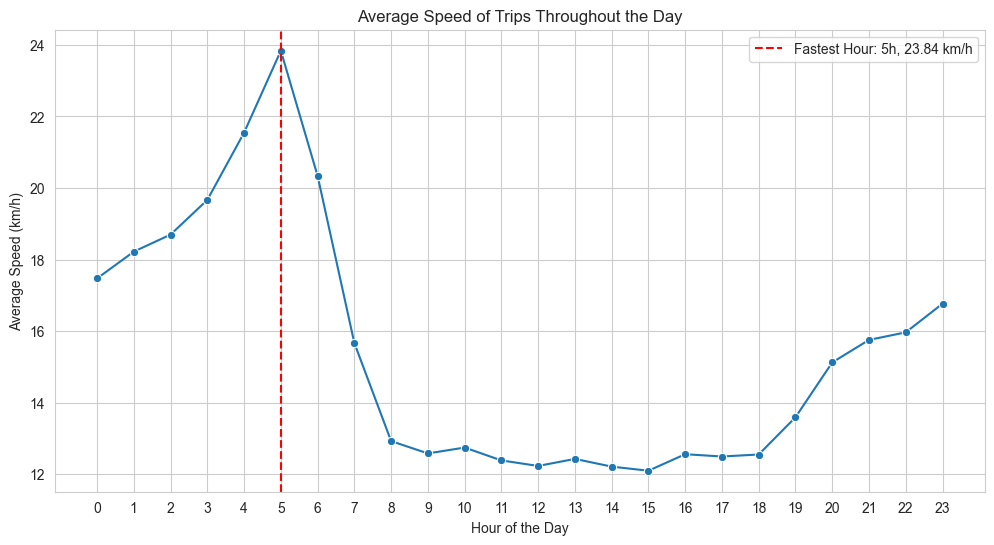

The fastest time of day is around 5:00 with an average speed of 23.84 km/h.


<Figure size 640x480 with 0 Axes>

In [120]:
# Calculate the average speed per hour
avg_speed_per_hour = df.groupby('pickup_hour')['speed_kmh'].mean()

# Plot the average speed throughout the day
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_speed_per_hour.index, y=avg_speed_per_hour.values, marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed (km/h)')
plt.title('Average Speed of Trips Throughout the Day')
plt.xticks(range(0, 24))  # Ensuring all hours are shown on the x-axis
plt.grid(True)

# Highlight the hour(s) with the highest average speed
fastest_hour = avg_speed_per_hour.idxmax()
fastest_speed = avg_speed_per_hour.max()
plt.axvline(x=fastest_hour, color='red', linestyle='--', label=f'Fastest Hour: {fastest_hour}h, {fastest_speed:.2f} km/h')
plt.legend()

plt.savefig('./Plots/Plots[3]/Plots[3.5]/average_speed_throughout_day.png')

plt.show()
plt.clf()

print(f"The fastest time of day is around {fastest_hour}:00 with an average speed of {fastest_speed:.2f} km/h.")


### Question 4: Location clusters
**[4.1]** Heatmaps

Produce a heatmap of all of the trip pickups over (do not do a scatter plot... there are 1.5 million data points and this will almost certainly crash your computer):
1. weekdays and weekends,
2. morning and evening (choose reasonable hours).

Comment on any findings you make.

In [121]:
df['weekend'] = df['day_of_week'].isin([5, 6])
#weekday vs. weekend heatmap
weekend_pickups = df[df['weekend']][['pickup_latitude', 'pickup_longitude']].dropna()
weekday_pickups = df[~df['weekend']][['pickup_latitude', 'pickup_longitude']].dropna()

#morning vs. evening heatmap
morning_pickups = df[df['time_of_day'] == 'Morning'][['pickup_latitude', 'pickup_longitude']].dropna()
evening_pickups = df[df['time_of_day'] == 'Evening'][['pickup_latitude', 'pickup_longitude']].dropna()

# Create a map centered at a reasonable location (e.g., the average pickup location)
center_lat, center_long = df['pickup_latitude'].mean(), df['pickup_longitude'].mean()

#Weekday vs. Weekend heatmap
map_weekend = folium.Map(location=[center_lat, center_long], zoom_start=10, tiles='Cartodb dark_matter')
HeatMap(weekend_pickups.values.tolist()).add_to(map_weekend)
map_weekend.save('heatmap_weekend_pickups.html')
del map_weekend

map_weekday = folium.Map(location=[center_lat, center_long], zoom_start=10, tiles='Cartodb dark_matter')
HeatMap(weekday_pickups.values.tolist()).add_to(map_weekday)
map_weekday.save('heatmap_weekday_pickups.html')
del map_weekday

#Morning vs. Evening heatmap
map_morning = folium.Map(location=[center_lat, center_long], zoom_start=10, tiles='Cartodb dark_matter')
HeatMap(morning_pickups.values.tolist()).add_to(map_morning)
map_morning.save('heatmap_morning_pickups.html')
del map_morning

map_evening = folium.Map(location=[center_lat, center_long], zoom_start=10, tiles='Cartodb dark_matter')
HeatMap(evening_pickups.values.tolist()).add_to(map_evening)
map_evening.save('heatmap_evening_pickups.html')
del map_evening
gc.collect()

print("maps have been saved to html files")

maps have been saved to html files


1. During weekdays, the heatmap reveals a much broader area of activity, extending out to places like Paterson and West Babylon, likely reflecting the commuter patterns of people traveling to work. Central New York is particularly busy, showcasing the city's weekday hustle. On weekends, however, the activity contracts, with significantly fewer pickups in areas like Paterson and West Babylon, suggesting these spots are less frequented outside of workdays. The busiest areas on the weekend are concentrated around Central New York, though some places, like Stamford, experience a slight increase in activity.
2. In the morning, Central New York is busy with activity, with pickups occurring over a slightly larger area compared to the evening, probably from people going to work. While the evening remains busy, areas like Stamford and Paterson see significantly fewer pickups, suggesting these locations may not be as popular for evening outings. One constant, however, is the area around Central Park, which remains a hotspot for pickups throughout both times of the day.

**[4.2]** Hotspots

If you were a taxi driver wanting to plan your evenings so that you could get the most trips, you would want to know where the popular areas are. Looking at the time periods 23:00 on a Friday evening to 02:00 on a Saturday morning, and between 17:00 and 20:00 on a Thursday, find hotspot locations (areas where there are a large number of trips happening). If you were to use k-means, you would define the number of clusters. However, here the number of clusters is not at all clear. DBSCAN (available in sklearn) determines this for you, and works well on spatial data. DBSCAN has two configurable parameters: ε-the maximum distance between any two points, and the minimum number of samples to determine a cluster. Your hotspot location might be defined as at least 15 pickups in that location in an hour, and locations might be required to be within 50 or 100 metres from each other (motivate your choice of parameters). Using DBSCAN, identify clusters and plot these on a map. How many clusters did you find? 

Number of clusters: 59


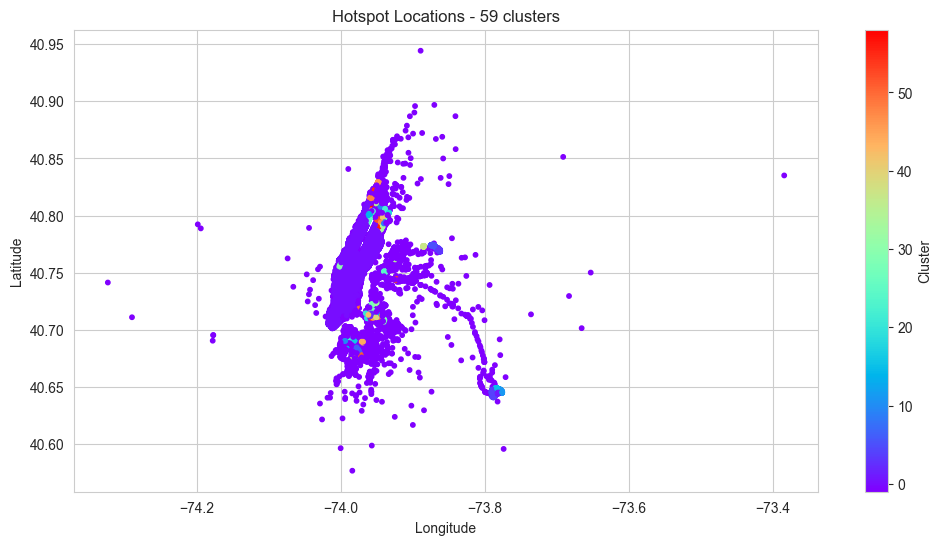

maps have been saved to html files


In [122]:
friday_evening = df[(df['pickup_datetime'].dt.dayofweek == 4) & 
                      (df['pickup_datetime'].dt.hour >= 23) | 
                      (df['pickup_datetime'].dt.dayofweek == 5) & 
                      (df['pickup_datetime'].dt.hour < 2)]

thursday_evening = df[(df['pickup_datetime'].dt.dayofweek == 3) & 
                        (df['pickup_datetime'].dt.hour >= 17) & 
                        (df['pickup_datetime'].dt.hour < 20)]

planning_data = pd.concat([friday_evening, thursday_evening])
coords = planning_data[['pickup_latitude', 'pickup_longitude']].values

max_distance = 0.1  #0.1 because thats 100m in km
min_cars = 15
kms_per_radian = 6371.0088
epsilon = max_distance / kms_per_radian
#apply DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_cars, algorithm='ball_tree', metric='haversine')
clusters = db.fit_predict(np.radians(coords))

#add the cluster labels back to the dataframe
planning_data['cluster'] = clusters

#number of clusters
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"Number of clusters: {n_clusters}")

# Plot the clusters on a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(planning_data['pickup_longitude'], planning_data['pickup_latitude'], c=planning_data['cluster'], cmap='rainbow', s=10)
plt.title(f"Hotspot Locations - {n_clusters} clusters")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.savefig('./Plots/Plots[4]/Plots[4.2]/clusters_scatter_plot.png')
plt.show()

#coordinates of New York City
nyc_lat, nyc_lon = 40.7128, -74.0060
cluster_map = folium.Map(location=[nyc_lat, nyc_lon], tiles="CartoDB Positron", zoom_start=11)
colormap = plt.get_cmap('tab20')
#add DBSCAN clusters to the map
for lat, lon, cluster in zip(planning_data['pickup_latitude'], planning_data['pickup_longitude'], planning_data['cluster']):
    if cluster != -1:
        color = colormap(cluster % colormap.N)  # Normalize to 0-1 range for color mapping
        color = f'#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}'  # Convert to hex
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6
        ).add_to(cluster_map)
cluster_map.save('nyc_cluster_map.html')
del cluster_map
gc.collect()

print("maps have been saved to html files")

### Question 5: Airports

Find out how long it takes, on average, to travel to JFK airport from the Empire State Building. Produce a plot showing the travel time by time of day. How does this compare with Newark Airport? Assume the following coordinates for the centre point of the locations (long, lat):

- JFK Airport: (40.647929, -73.777813)
- Empire State Building: (40.756724, -73.983806)
- Newark Airport: (40.689442, -74.173242)

Use a reasonable (and motivate!) radius around these locations when determining if a GPS coordinate is at that location. [9 marks]

To do / plan:

- how long it takes to get to JFK from Empire State Building.
- pick a revelent radius for the airports and building
- calculate travel times
- separate/ organise by time of the day.
- plot graph, histogram?

travel time:  trip_duration_min
locations:
    start: pickup_longitude and pickup_latitude
    end: dropoff_longitude and dropoff_latitude

- new dataframe that has:
    - only data from relevant trips ( ie the airport trips)
    - travel times
    - time of day of the trips

#### Explanations / Answers Q5

JFK:
- On average it takes 49.48 mintues to get to JFK airport from the Empire State Building.
- It takes the longest to get to JFK from the Empire State building in the afternoon and the shortest at night.

Newark:
- On average it takes 36.33 minutes to get to Newark airport from the Empire State Building.
- It takes the longest to get to Newark from the Empire State Building in the evening and the shortest at night.

On average it takes longer to get to JFK airport than it takes to get to Newark airport from the Empire State building. At any time of day it takes longer to get to JFK airport than it does to get to Newark Airport. The general trends of the trip durations at the different times of days is the same for both airports, with the only slight diffference being that the longest duration trip is in the afternoon for JFK and in the evening for Newark. The second longest trip durations are in the evening and afternoon for JFK airport and Newark airport respectively. The shortest for both is at night and the second shorted is in the morning for both as well.

The haversine function was used to fine the distances between the pickup and dropoff locations and the Empire State Building and airports respectively. These distances were checked if they were smaller than the defined radius to determine if the pickup and dropoff points were located at the Empire State building and the airports. The pandas dataframe was modified to only contain the trips from the Empire State Building to the different airports. The average of the different trip durations was calculated for each time of day.

Radius motivation:
We decided to have 3 different radius values for the 3 different locations. The coordinates of the different locations is the coordinates of the center of the location. Therefore, it would be unfair to use the same radius for the Empire State building and for JFK airport as these  2 locations are vastly different in size.

The radius values for the 3 different locations was determined by looking at the area that the location takes up and the context of the location.

The radius value for the Empire state building was decided to be 500m. This is beacuse the Empire State Buiding does not take up that much area on thr ground. The Empire State Building is also in the dense city, meaning having a radius that is too big will result in incorrectly classifying pickup locations that are not specifically at the Empire State building to be at the Empire State Building. We did try different values for this radius, for example we tries 100 meters but found that this would result in there being too little trips included in order to accurately assess the travel durations for the trips to the airport.

The radius values for the airports was determined by googling the surface area of the different airports. we used this surface area as the approximate circular area of the airports. A caluclation was done to determine the radius of a circle with this area.

- The area of JFK airport is 21.04km^2. The radius of a circle that has the area of 21.04km^2 is 2.588km.
- The area of Newark airport is 8.20 km^2. The radius of a circle that has the area of 8.20 km^2 is 1.6156 km.

Therfore we decided to make the radius of the JFK airport 3.5 km and the radius of Newark airport 2.5 km. This is about 1km greater than the approximate circular radius, and this is to account for ubers/taxis not dropping off customers directly at the airport perimeter. This increase opf the radius is to help increase the amount of datapoints available in order to accurately calculate the average duration of the trips, as explained above with the Empire State Building radius. The radius for the airports can also be increased more as the aiports will be in a more open area of New York, meaning that dropoff points will be less likley to be misclassified as the arirports.

In [123]:
airport_trips_traveltimes_df = df.copy()
not_relevant_columns = airport_trips_traveltimes_df.columns.to_list()
not_relevant_columns.remove("pickup_longitude")
not_relevant_columns.remove("pickup_latitude")
not_relevant_columns.remove("dropoff_longitude")
not_relevant_columns.remove("dropoff_latitude")
not_relevant_columns.remove("trip_duration_min")
not_relevant_columns.remove("time_of_day")
not_relevant_columns.remove("pickup_hour")
airport_trips_traveltimes_df.drop(not_relevant_columns, axis=1, inplace=True)

def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = builtins.map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# JFK = JFK Airport
# ESB = Empire State Building
# Newark = Newark Airport

JFK_LAT =  40.647929
JFK_LONG =  -73.777813

ESB_LAT =  40.756724
ESB_LONG = -73.983806

NEWARK_LAT = 40.689442
NEWARK_LONG = -74.173242

radius_esb = 0.5 
radius_jfk = 3.5
radius_newark = 2.5

        
def pickupLocation(row):
    pickup_long = row['pickup_longitude']
    pickup_lat =  row['pickup_latitude']
    if haversine_np(ESB_LONG, ESB_LAT, pickup_long, pickup_lat) <= radius_esb:
        return "ESB"
    elif haversine_np(JFK_LONG, JFK_LAT, pickup_long, pickup_lat) <= radius_jfk:
        return "JFK"
    elif haversine_np(NEWARK_LONG, NEWARK_LAT, pickup_long, pickup_lat) <= radius_newark:
        return "Newark"
    else:
        return "NA"
    
def dropoffLocation(row):
    dropoff_long = row['dropoff_longitude']
    dropoff_lat = row['dropoff_latitude']
    if haversine_np(ESB_LONG, ESB_LAT, dropoff_long, dropoff_lat) <= radius_esb:
        return "ESB"
    elif haversine_np(JFK_LONG, JFK_LAT, dropoff_long, dropoff_lat) <= radius_jfk:
        return "JFK"
    elif haversine_np(NEWARK_LONG, NEWARK_LAT, dropoff_long, dropoff_lat) <= radius_newark:
        return "Newark"
    else:
        return "NA"


airport_trips_traveltimes_df['pickup_location'] = ""
airport_trips_traveltimes_df['dropoff_location'] = ""

airport_trips_traveltimes_df['pickup_location'] = airport_trips_traveltimes_df.apply(pickupLocation, axis = 1)
airport_trips_traveltimes_df['dropoff_location'] = airport_trips_traveltimes_df.apply(dropoffLocation, axis = 1)

airport_trips_traveltimes_df = airport_trips_traveltimes_df[(airport_trips_traveltimes_df['pickup_location'] == "ESB") & ((airport_trips_traveltimes_df['dropoff_location'] == "JFK") |(airport_trips_traveltimes_df['dropoff_location'] == "Newark")) ]

display(airport_trips_traveltimes_df)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,time_of_day,trip_duration_min,pickup_location,dropoff_location
1901,-73.984,40.759,-73.776,40.645,9,Morning,56.417,ESB,JFK
1914,-73.986,40.753,-74.177,40.691,14,Afternoon,26.317,ESB,Newark
5885,-73.985,40.754,-74.177,40.695,12,Afternoon,33.567,ESB,Newark
8421,-73.987,40.760,-73.790,40.647,16,Afternoon,77.683,ESB,JFK
10656,-73.988,40.759,-74.179,40.709,15,Afternoon,32.717,ESB,Newark
...,...,...,...,...,...,...,...,...,...
1440702,-73.979,40.756,-73.807,40.659,18,Evening,32.850,ESB,JFK
1443588,-73.989,40.757,-73.782,40.644,23,Night,41.883,ESB,JFK
1444714,-73.980,40.755,-73.783,40.649,9,Morning,25.700,ESB,JFK
1444887,-73.985,40.759,-73.786,40.644,18,Evening,50.017,ESB,JFK


In [124]:
esb_jfk_trip = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "JFK"]
esb_jfk_trip_duration = esb_jfk_trip['trip_duration_min']
esb_jfk_trip_duration_average = esb_jfk_trip_duration.mean()
print("Average time to get from Empire State Building to JFK Airport: "+str(esb_jfk_trip_duration_average))

Average time to get from Empire State Building to JFK Airport: 49.48724508713385


In [125]:
esb_newark_trip = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "Newark"]
esb_newark_trip_duration = esb_newark_trip['trip_duration_min']
esb_newark_trip_duration_average = esb_newark_trip_duration.mean()
print("Average time to get from Empire State Building to Newark Airport: "+str(esb_newark_trip_duration_average))

Average time to get from Empire State Building to Newark Airport: 36.32895480225989


In [126]:
# get average trip durtion per time of day

esb_newark_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "Newark"]
esb_newark_trip_duration_afternoon = esb_newark_trip_duration[esb_newark_trip_duration['time_of_day'] == "Afternoon"]['trip_duration_min']
esb_newark_trip_duration_afternoon_average = esb_newark_trip_duration_afternoon.mean()

esb_jfk_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "JFK"]
esb_jfk_trip_duration_afternoon = esb_jfk_trip_duration[esb_jfk_trip_duration['time_of_day'] == "Afternoon"]['trip_duration_min']
esb_jfk_trip_duration_afternoon_average = esb_jfk_trip_duration_afternoon.mean()

esb_newark_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "Newark"]
esb_newark_trip_duration_evening = esb_newark_trip_duration[esb_newark_trip_duration['time_of_day'] == "Evening"]['trip_duration_min']
esb_newark_trip_duration_evening_average = esb_newark_trip_duration_evening.mean()

esb_jfk_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "JFK"]
esb_jfk_trip_duration_evening = esb_jfk_trip_duration[esb_jfk_trip_duration['time_of_day'] == "Evening"]['trip_duration_min']
esb_jfk_trip_duration_evening_average = esb_jfk_trip_duration_evening.mean()

esb_newark_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "Newark"]
esb_newark_trip_duration_morning = esb_newark_trip_duration[esb_newark_trip_duration['time_of_day'] == "Morning"]['trip_duration_min']
esb_newark_trip_duration_morning_average = esb_newark_trip_duration_morning.mean()

esb_jfk_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "JFK"]
esb_jfk_trip_duration_morning = esb_jfk_trip_duration[esb_jfk_trip_duration['time_of_day'] == "Morning"]['trip_duration_min']
esb_jfk_trip_duration_morning_average = esb_jfk_trip_duration_morning.mean()

esb_newark_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "Newark"]
esb_newark_trip_duration_night = esb_newark_trip_duration[esb_newark_trip_duration['time_of_day'] == "Night"]['trip_duration_min']
esb_newark_trip_duration_night_average = esb_newark_trip_duration_night.mean()

esb_jfk_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "JFK"]
esb_jfk_trip_duration_night = esb_jfk_trip_duration[esb_jfk_trip_duration['time_of_day'] == "Night"]['trip_duration_min']
esb_jfk_trip_duration_night_average = esb_jfk_trip_duration_night.mean()



print("ESB to Newark in Afternoon: " + str(esb_newark_trip_duration_afternoon_average))
print("ESB to JFK in Afternoon: " + str(esb_jfk_trip_duration_afternoon_average))
print("ESB to Newark in Evening: " + str(esb_newark_trip_duration_evening_average))
print("ESB to JFK in Evening: " + str(esb_jfk_trip_duration_evening_average))
print("ESB to Newark in Morning: " + str(esb_newark_trip_duration_morning_average))
print("ESB to JFK in Morning: " + str(esb_jfk_trip_duration_morning_average))
print("ESB to Newark at night: " + str(esb_newark_trip_duration_night_average))
print("ESB to JFK at night: " + str(esb_jfk_trip_duration_night_average))

trip_duration_averages_jfk = {"Morning": esb_jfk_trip_duration_morning_average,"Afternoon": esb_jfk_trip_duration_afternoon_average,"Evening": esb_jfk_trip_duration_evening_average, "Night": esb_jfk_trip_duration_night_average}
trip_duration_jfk = {"Morning": esb_jfk_trip_duration_morning,"Afternoon": esb_jfk_trip_duration_afternoon,"Evening": esb_jfk_trip_duration_evening, "Night": esb_jfk_trip_duration_night}

trip_duration_averages_newark = {"Morning": esb_newark_trip_duration_morning_average,"Afternoon": esb_newark_trip_duration_afternoon_average,"Evening": esb_newark_trip_duration_evening_average, "Night": esb_newark_trip_duration_night_average}
trip_duration_newark = {"Morning": esb_newark_trip_duration_morning,"Afternoon": esb_newark_trip_duration_afternoon,"Evening": esb_newark_trip_duration_evening, "Night": esb_newark_trip_duration_night}

ESB to Newark in Afternoon: 40.041590214067284
ESB to JFK in Afternoon: 55.58734082397003
ESB to Newark in Evening: 40.66228070175438
ESB to JFK in Evening: 54.37874720357942
ESB to Newark in Morning: 32.38333333333333
ESB to JFK in Morning: 39.14970501474926
ESB to Newark at night: 27.309722222222224
ESB to JFK at night: 35.473417721518985


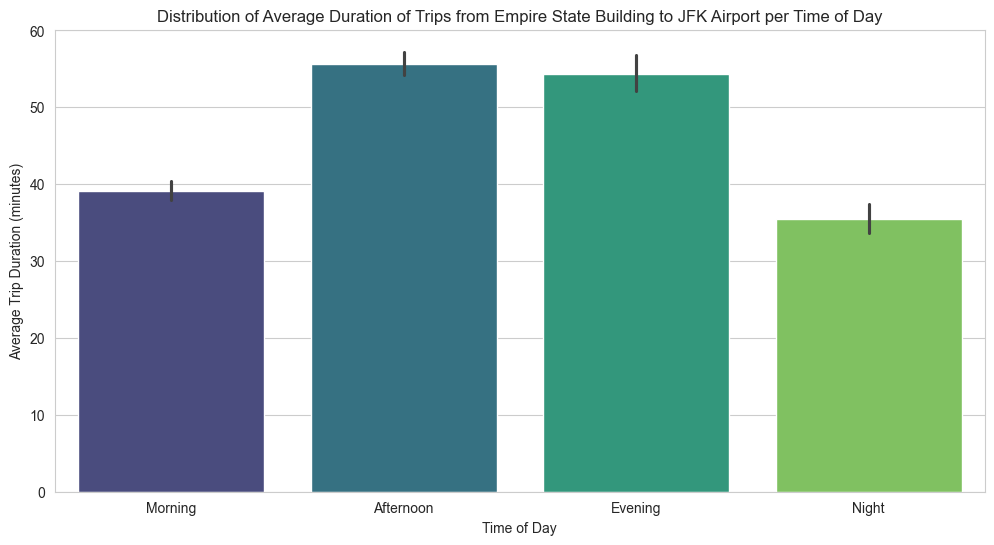

<Figure size 640x480 with 0 Axes>

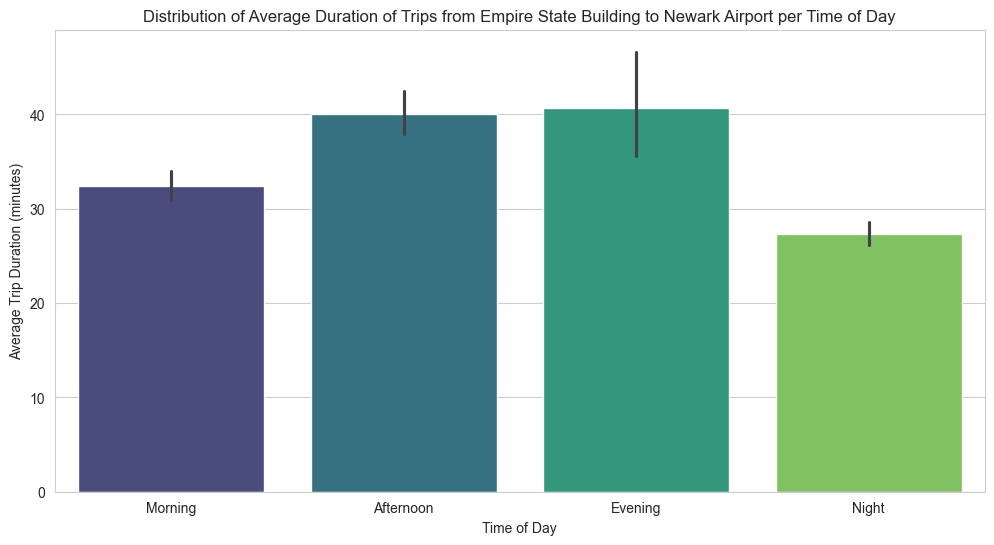

<Figure size 640x480 with 0 Axes>

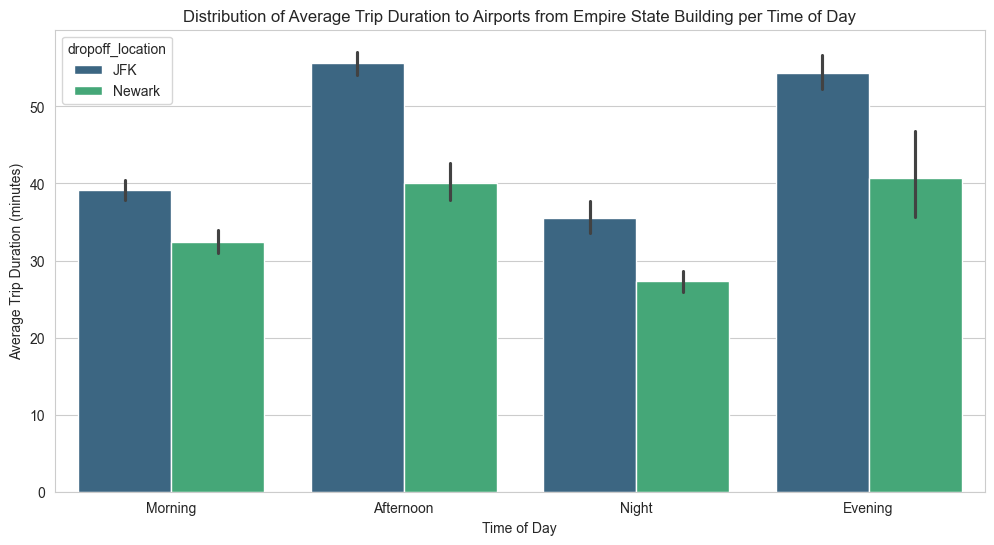

<Figure size 640x480 with 0 Axes>

In [127]:
plt.figure(figsize=(12, 6))
sns.barplot(trip_duration_jfk, palette='viridis')
plt.xlabel('Time of Day')
plt.ylabel('Average Trip Duration (minutes)')
plt.title('Distribution of Average Duration of Trips from Empire State Building to JFK Airport per Time of Day')
plt.savefig( './Plots/Plots[5]/trip_duration_ESB_to_JFK_per_time_of_day.png')
plt.show()
plt.clf()

plt.figure(figsize=(12, 6))
sns.barplot(trip_duration_newark, palette='viridis')
plt.xlabel('Time of Day')
plt.ylabel('Average Trip Duration (minutes)')
plt.title('Distribution of Average Duration of Trips from Empire State Building to Newark Airport per Time of Day')
plt.savefig('./Plots/Plots[5]/trip_duration_ESB_to_Newark_per_time_of_day.png')
plt.show()
plt.clf()

plt.figure(figsize=(12, 6))
sns.barplot(data=airport_trips_traveltimes_df, x='time_of_day', y='trip_duration_min', hue='dropoff_location', palette='viridis')
plt.xlabel('Time of Day')
plt.ylabel('Average Trip Duration (minutes)')
plt.title('Distribution of Average Trip Duration to Airports from Empire State Building per Time of Day')
plt.savefig('./Plots/Plots[5]/trip_duration_from_ESB_both_airports_per_time_of_day.png')
plt.show()
plt.clf()

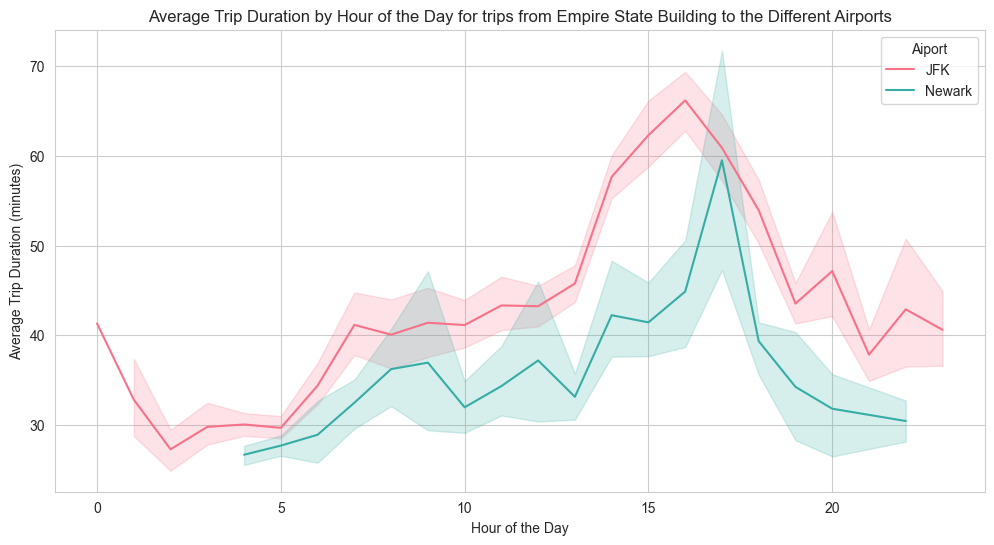

<Figure size 640x480 with 0 Axes>

In [128]:
plt.figure(figsize=(12, 6))
palette = sns.color_palette("husl", 2)
sns.lineplot(data=airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "JFK"], x='pickup_hour', y='trip_duration_min', label='JFK', color=palette[0])
sns.lineplot(data=airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "Newark"], x='pickup_hour', y='trip_duration_min', label='Newark', color=palette[1])
plt.xlabel('Hour of the Day')
plt.ylabel('Average Trip Duration (minutes)')
plt.title('Average Trip Duration by Hour of the Day for trips from Empire State Building to the Different Airports')
plt.legend(title='Aiport')
plt.savefig('./Plots/Plots[5]/line_graph_trip_duration_from_ESB_both_airports_hour_of_day.png')
plt.show()
plt.clf()